In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from scipy.spatial import distance
from sklearn.feature_selection import VarianceThreshold
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams['pdf.fonttype'] = 42 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, lasso_path
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import statsmodels.api as sm

In [3]:
def get_matched_pair_set(pairs):
    pair_set = []
    for i in pairs.index:
        for j in pairs.loc[i, :]:
            pair_set.append([i, j])
    pair_set = pd.DataFrame(pair_set, columns=['Case', 'Control'])
    pair_set = pair_set.dropna(how='any')
    return pair_set

def load_resdata(project, path='../Temp/'):
    ### matched result
    matched = pd.read_csv(path+project+'/PSM_Matched.tsv', index_col=0, sep='\t')
    taxa_diff = pd.read_csv(path+project+'/Microbiome_difference.csv', index_col=0).fillna(0)
    path_diff = pd.read_csv(path+project+'/Pathway_difference.csv', index_col=0).fillna(0)
    pairs = pd.read_csv(path+project+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
    pairs = pairs.replace('NA_character_',np.nan)
    pair_set = get_matched_pair_set(pairs)
    ### Raw data
    metadata = pd.read_csv(path+project+'/Metadata.csv', index_col=0)
    microbiome = pd.read_csv(path+project+'/Microbiome.csv', index_col=0)
    pathway = pd.read_csv(path+project+'/Pathway.csv', index_col=0)
    return metadata, matched, taxa_diff, path_diff, pair_set, microbiome, pathway

# case-control cohorts

In [5]:
path = '../Temp/'
projects = [i for i in os.listdir(path) if '.csv' not in i and '.ipynb_checkpoints' not in i and '.DS_Store' not in i and '.RData' not in i and '.Rhistory' not in i]
len(projects), projects[:5]
projects

(88, ['08', '09', '100', '101', '11'])

['08',
 '09',
 '100',
 '101',
 '11',
 '15',
 '18_1',
 '18_2',
 '18_3',
 '24_1',
 '24_2',
 '24_3',
 '26',
 '27',
 '28_1',
 '28_2',
 '28_3',
 '30',
 '36',
 '37_1',
 '37_2',
 '37_3',
 '38',
 '39',
 '40_1',
 '40_2',
 '40_3',
 '43',
 '44',
 '48_1',
 '48_2',
 '48_3',
 '48_4',
 '48_5',
 '48_6',
 '49_1',
 '49_2',
 '49_3',
 '50_1',
 '50_2',
 '50_3',
 '54_1',
 '54_2',
 '54_3',
 '58',
 '59',
 '68',
 '69',
 '71',
 '72',
 '73',
 '74',
 '76',
 '78',
 '81_1',
 '81_2',
 '81_3',
 '82',
 '83',
 '84_1',
 '84_10',
 '84_11',
 '84_14',
 '84_15',
 '84_17',
 '84_2',
 '84_4',
 '84_5',
 '84_7',
 '84_8',
 '84_9',
 '86',
 '87',
 '91',
 '92_1',
 '92_2',
 '92_3',
 '93_1',
 '93_2',
 '93_3',
 '93_4',
 '93_5',
 '93_6',
 '96',
 '97',
 '99_1',
 '99_2',
 '99_3']

In [6]:
projects_message=pd.read_csv('../Label/fenzu.csv',index_col=0).T
projects_message=projects_message.to_dict('list')
projects_message

{'01': ['AsnicarF_2017', 'milk', 'control', nan],
 '02': ['AsnicarF_2017', 'stool', 'control', nan],
 '03': ['AsnicarF_2021', 'stool', 'control', nan],
 '04': ['BackhedF_2015', 'stool', 'control', nan],
 '05': ['Bengtsson-PalmeJ_2015', 'stool', 'control', nan],
 '06': ['BritoIL_2016', 'oralcavity', 'control', nan],
 '07': ['BritoIL_2016', 'stool', 'control', nan],
 '08': ['BrooksB_2017', 'stool', 'control', 'premature_born'],
 '09': ['Castro-NallarE_2015', 'oralcavity', 'control', 'schizofrenia'],
 '10': ['ChengpingW_2017', 'stool', 'AS', nan],
 '11': ['ChngKR_2016', 'skin', 'control', 'AD'],
 '12': ['ChuDM_2017', 'oralcavity', 'control', nan],
 '13': ['ChuDM_2017', 'stool', 'control', nan],
 '14': ['CosteaPI_2017', 'stool', 'control', nan],
 '15': ['DavidLA_2015', 'stool', 'control', 'acute_diarrhoea'],
 '16': ['DeFilippisF_2019', 'stool', 'control', nan],
 '17': ['DhakanDB_2019', 'stool', 'control', nan],
 '18_1': ['FengQ_2015', 'stool', 'control', 'adenoma'],
 '18_2': ['FengQ_2015',

### 1. PSM Score

,Project,Control,Case,Control_matched,Case_matched,Delta_Unmatched,Delta_Matched
0,08,0.938393,0.988357,0.983176,0.983748,0.049964,0.000572
1,09,0.373933,0.626067,0.627506,0.631632,0.252133,0.004126


Wilcoxon p=3.732e-16


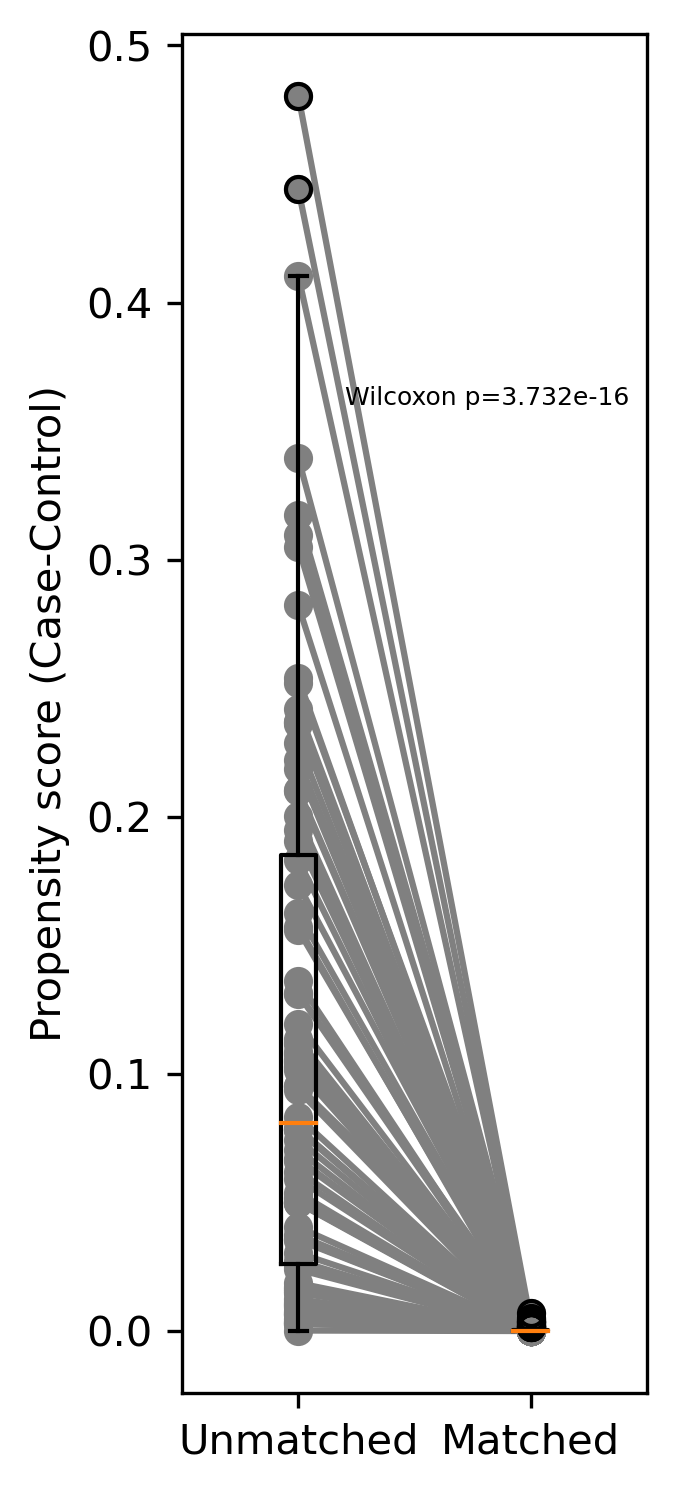

In [7]:
result = []
for project in projects:
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    x = matched.loc[matched['Group']==0, 'distance']
    y = matched.loc[matched['Group']==1, 'distance']
    x_matched = matched.loc[pairs['Control'], 'distance']
    y_matched = matched.loc[pairs['Case'], 'distance']
    result.append([project, x.mean(), y.mean(), x_matched.mean(), y_matched.mean(), y.mean() - x.mean(), abs(y_matched.mean() - x_matched.mean())])
result = pd.DataFrame(result, columns=['Project', 'Control', 'Case', 'Control_matched', 'Case_matched', 'Delta_Unmatched', 'Delta_Matched'])
result.head(2)
#result.to_csv('../Results/Results2/2.PSMdata.csv')

p = stats.wilcoxon(result['Delta_Unmatched'], result['Delta_Matched'], alternative='two-sided')[1]
print('Wilcoxon p=%.3e' % p)

_ = plt.figure(0, (2, 6), dpi=300)
for i in result.index:
    _ = plt.plot([1, 2], result.loc[i, ['Delta_Unmatched', 'Delta_Matched']], '-o', alpha=1, color='gray')
_ = plt.boxplot([result['Delta_Unmatched'], result['Delta_Matched']])
_ = plt.annotate('Wilcoxon p=%.3e'%p, (1.2, 0.36), fontsize=6)
_ = plt.ylabel('Propensity score (Case-Control)')
_ = plt.xticks([1, 2], ['Unmatched', 'Matched'])
#plt.savefig('../Results/2.psm_boxplot.pdf',bbox_inches = 'tight')
_ = plt.show()

### 2. meaningful features

In [7]:
PS_threshold = 0.05
Features = ['Baseline', 'Case', 'Antibiotic', 'Age', 'Country'] #, 'Site', 'Kit', 'Baseline', 'Case', 

result = []
for project in projects:
    _, site, control, case = projects_message[project]
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    x = matched.loc[matched['Group']==0, 'distance']
    y = matched.loc[matched['Group']==1, 'distance']
    delta_ps = y.mean() - x.mean()
    if 'antibiotics_current_use' in metadata.columns:
        anti = list(set(metadata['antibiotics_current_use'].dropna()))
        anti = 'Mix' if len(anti)>1 else (anti[0] if len(anti)==1 else np.nan)
    else:
        anti = np.nan
    if 'age_category' in metadata.columns:
        age = list(set(metadata['age_category'].dropna()))
        age = 'Mix' if len(age)>1 else (age[0] if len(age)==1 else np.nan)
    else:
        age = np.nan
    if 'country' in metadata.columns:
        country = list(set(metadata['country'].dropna()))
        country = 'Mix' if len(country)>1 else (country[0] if len(country)==1 else np.nan)
    else:
        country = np.nan
    if 'DNA_extraction_kit' in metadata.columns:
        kit = list(set(metadata['DNA_extraction_kit'].dropna()))
        kit = 'Mix' if len(kit)>1 else (kit[0] if len(kit)==1 else np.nan)
    else:
        kit = np.nan
    result.append([delta_ps, site, control, case, anti, age, country, kit])
result = pd.DataFrame(result, columns=['Delta_PS', 'Site', 'Baseline', 'Case', 'Antibiotic', 'Age', 'Country', 'Kit'], 
                      index = projects)
result = result.fillna('NA')
result = result.loc[result['Site']=='stool', :]

### Data Processing
enc = OneHotEncoder()
_ = enc.fit(result[Features])
Onehot_Features = enc.get_feature_names(Features)
encdata = pd.DataFrame(enc.transform(result[Features]).toarray(), columns=Onehot_Features, 
                       index=result.index)
encdata = pd.concat([result[['Delta_PS']], encdata], axis=1, sort=False)
encdata['Delta_PS_01'] = (encdata[['Delta_PS']]>=PS_threshold)+0
encdata[['Delta_PS_01']].groupby('Delta_PS_01').size()
### NA features delete
Onehot_Features = np.array([i for i in Onehot_Features if '_NA' not in i])
encdata = encdata.loc[:, [i for i in encdata.columns if '_NA' not in i]]

encdata.head(2)
#encdata.to_csv('../Results/Results2/2.encdata.csv')

Delta_PS_01
0    31
1    50
dtype: int64

,Delta_PS,Baseline_CRC,Baseline_FMT,Baseline_IBD,Baseline_IGT,Baseline_T1D,Baseline_carcinoma_surgery_history,Baseline_control,Baseline_fatty_liver,Baseline_hypertension,...,Country_FRA,Country_GBR,Country_IND,Country_ITA,Country_JPN,Country_LUX,Country_Mix,Country_NLD,Country_USA,Delta_PS_01
08,0.049964,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
100,0.040444,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### LASSO model

In [8]:
X = encdata.loc[:, Onehot_Features]
y = np.array(encdata['Delta_PS'])
X.head(2)
alphas, coefs, _ = lasso_path(X, y, eps=1e-4, positive=True) #forces the coefficients to be positive.
neg_log_alphas = -np.log10(alphas)

lasso_path_result = pd.concat([pd.DataFrame({'-log_alpha':neg_log_alphas,}), 
                               pd.DataFrame(coefs.T, columns=Onehot_Features)], axis=1, sort=False)


,Baseline_CRC,Baseline_FMT,Baseline_IBD,Baseline_IGT,Baseline_T1D,Baseline_carcinoma_surgery_history,Baseline_control,Baseline_fatty_liver,Baseline_hypertension,Baseline_migraine,...,Country_DEU,Country_FRA,Country_GBR,Country_IND,Country_ITA,Country_JPN,Country_LUX,Country_Mix,Country_NLD,Country_USA
08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:

anotas ={'Baseline_control':['Healthy', (1.50, 0.05)], 
         'Case_IBD':['IBD',(4.5,3.5)],
         'Case_ACVD':['ACVD',(4.5,3.5)],
         'Case_T2D':['T2D',(2.25,0.04)],
         'Age_Mix':['Age',(1.6,0.02)],
         'Country_IND':['Country_IND', (4.5, 0.34)], 
         'Country_NLD':['Country_NLD', (4.5, 0.21)], 
         'Case_acute_diarrhoea':['Acute_diarrhoea', (4.5, 0.3)], 
         'Case_cirrhosis':['Cirrhosis', (4.5, 0.125)]}

MannwhitneyuResult(statistic=656.0, pvalue=0.10797897510650743)

MannwhitneyuResult(statistic=25.0, pvalue=0.02212424121883972)

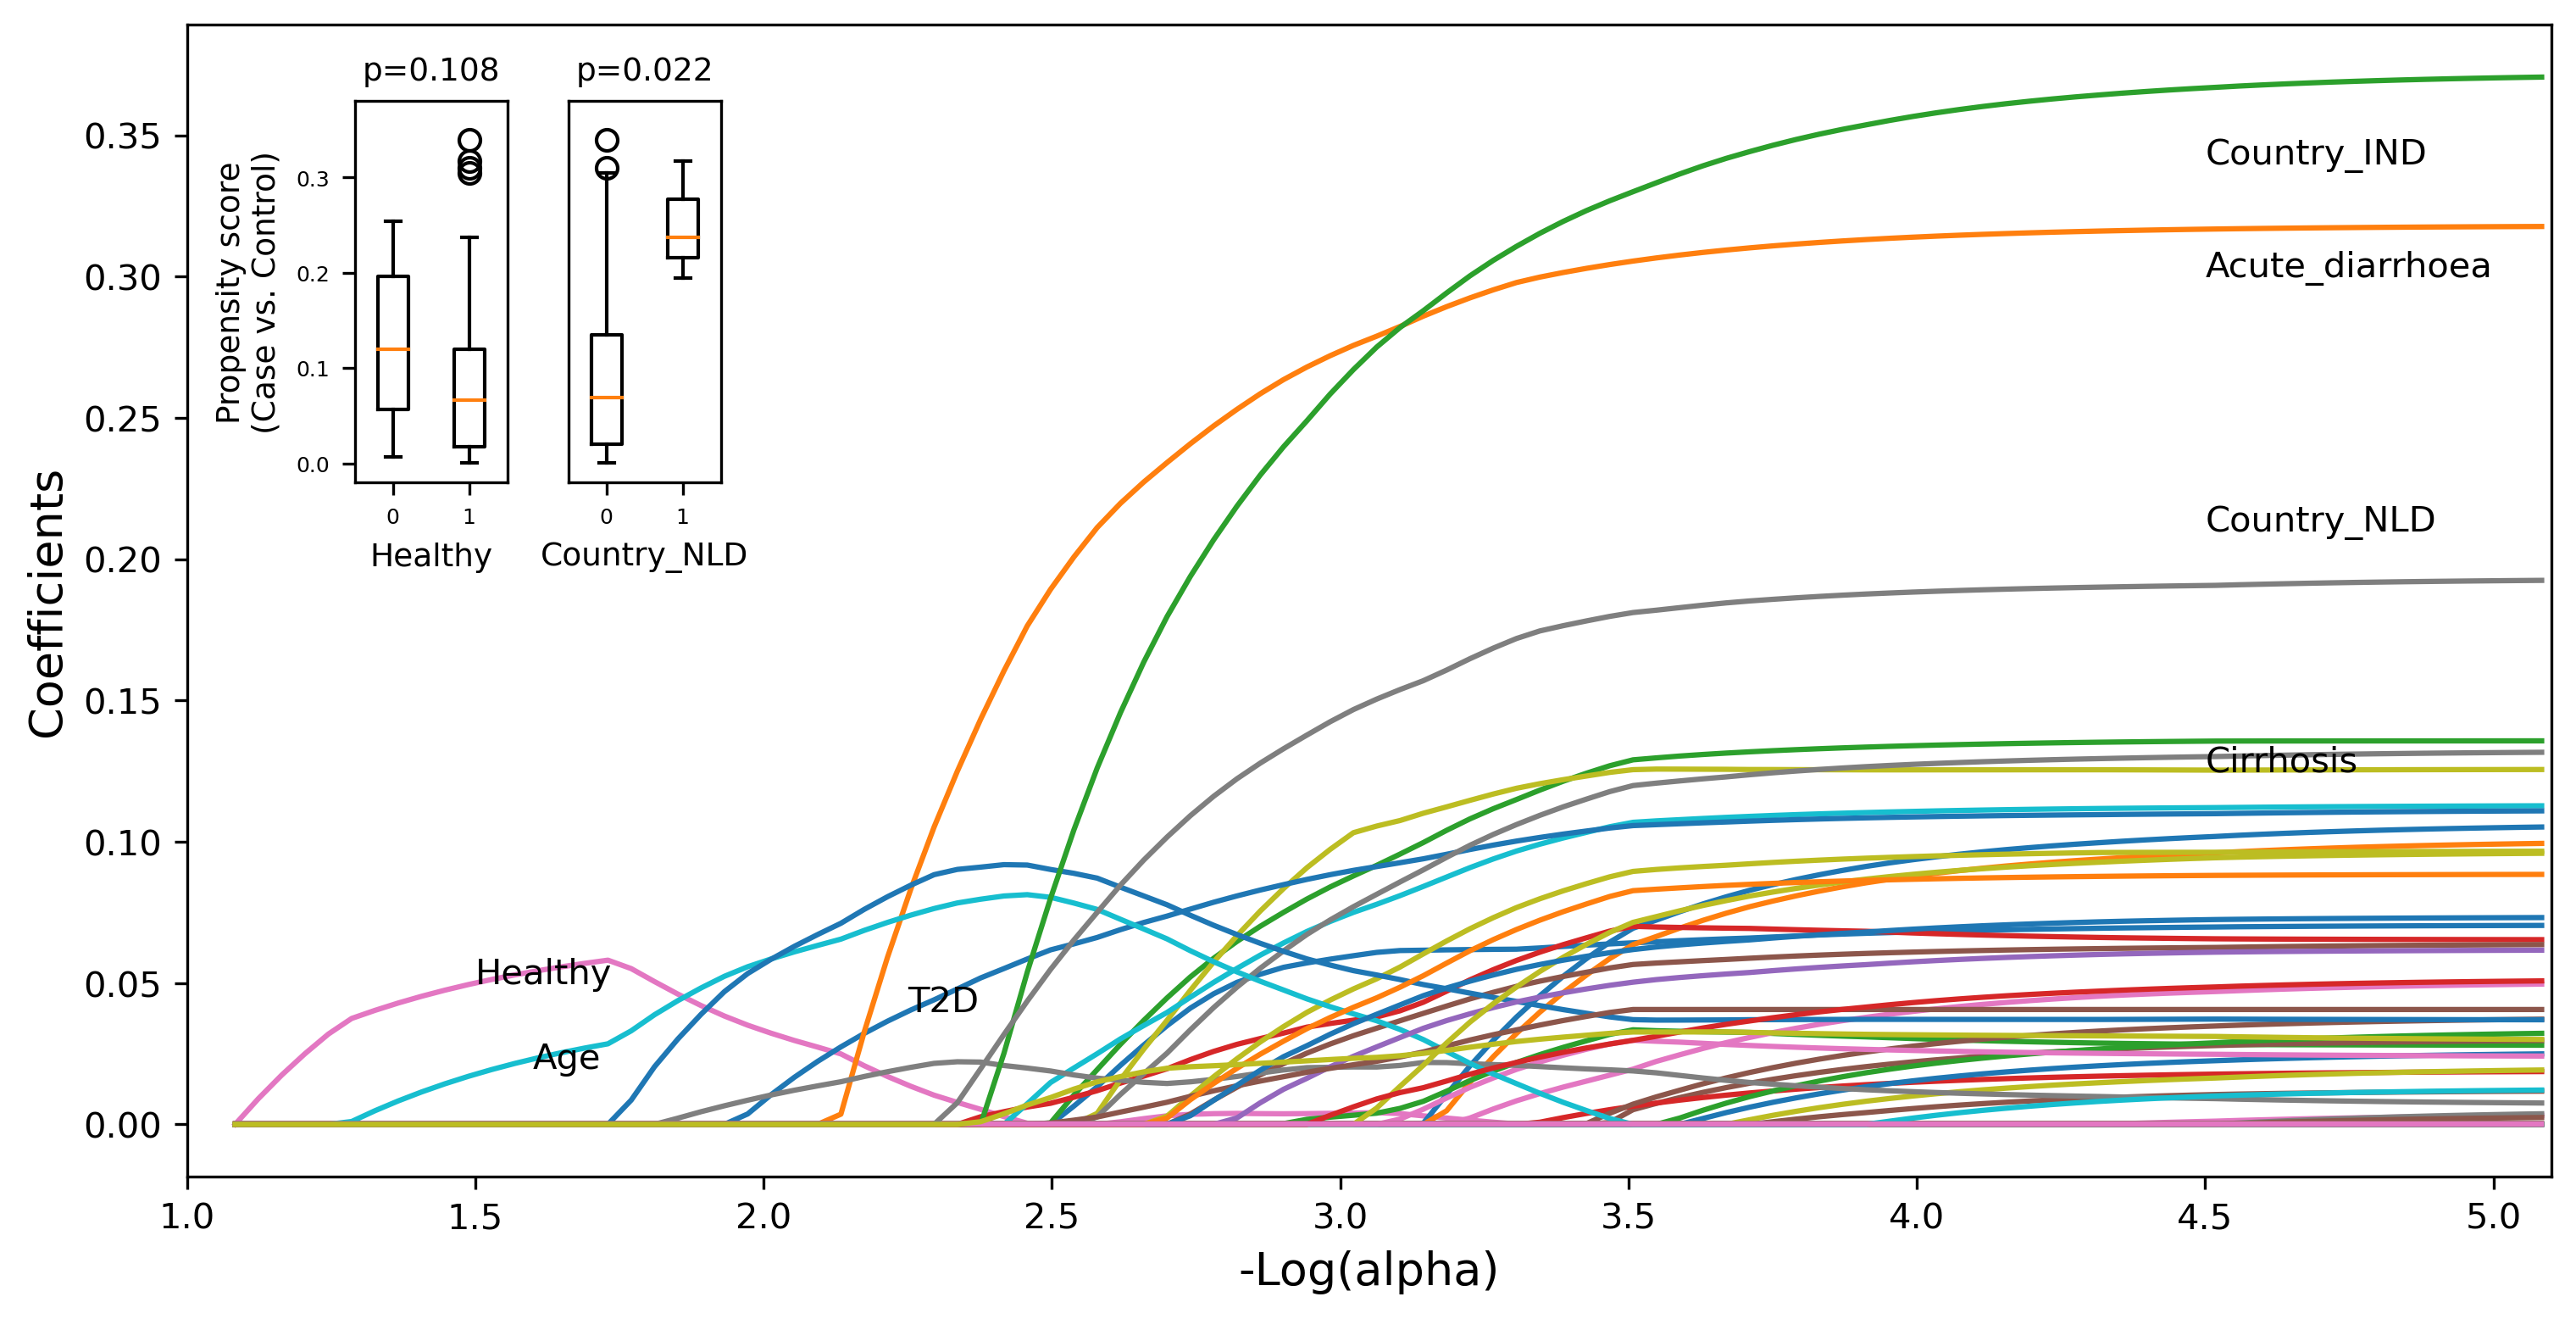

In [10]:
fig = plt.figure(0, (12, 6), dpi=300)
for i in range(len(coefs)):
    _ = plt.plot(neg_log_alphas, coefs[i])
    if coefs[i][np.argmax(coefs[i])]>=0.025:
        if X.columns[i] in anotas.keys():
            s, loc = anotas.get(X.columns[i], [X.columns[i], (neg_log_alphas[np.argmax(coefs[i])], coefs[i][np.argmax(coefs[i])])])
            _ = plt.annotate(s, loc)
_ = plt.xlabel('-Log(alpha)', fontsize=13)
_ = plt.ylabel('Coefficients', fontsize=13)
_ = plt.xlim([1.0, 5.1])

### statisitc
term = 'Baseline_control'
stats.mannwhitneyu(encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS'])
left, bottom, width, height = 0.18, 0.58, 0.05, 0.25
ax = fig.add_axes([left,bottom,width,height])
_ = ax.boxplot([encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS']], 
                widths=0.4)
_ = plt.xticks([1, 2], [0 ,1], fontsize=6)
_ = plt.yticks(fontsize=6)
_ = plt.ylim([-0.02, 0.38])
_ = ax.set_xlabel(anotas[term][0], fontsize=9)
_ = ax.set_ylabel('Propensity score\n(Case vs. Control)', fontsize=9)
_ = ax.set_title('p=0.108', fontsize=9)

term = 'Country_NLD'
stats.mannwhitneyu(encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS'])
left, bottom, width, height = 0.25, 0.58, 0.05, 0.25
ax = fig.add_axes([left,bottom,width,height])
_ = ax.boxplot([encdata.loc[encdata[term]==0, 'Delta_PS'], encdata.loc[encdata[term]==1, 'Delta_PS']], 
                widths=0.4)
_ = plt.xticks([1, 2], [0 ,1], fontsize=6)
_ = plt.yticks([])
_ = plt.ylim([-0.02, 0.38])
_ = ax.set_xlabel(anotas[term][0], fontsize=9)
_ = ax.set_title('p=0.022', fontsize=9)
#plt.savefig('../Results/Results2/2.factor_imbalance.pdf',bbox_inches = 'tight')
_ = plt.show()

### 3. age, gender, bmi...Results

In [8]:
fr = open("../Label/Meta_terms.txt",'r+')
Meta_terms = eval(fr.read())   
print(Meta_terms)
fr.close()

{'08': ['age', 'infant_age', 'age_category', 'gender', 'country', 'born_method', 'premature', 'birth_weight', 'gestational_age'], '09': ['age', 'age_category', 'gender', 'country', 'antibiotics_family'], '100': ['age', 'age_category', 'gender', 'country', 'BMI', 'smoker', 'dyastolic_p', 'systolic_p'], '101': ['age', 'age_category', 'gender', 'country', 'BMI'], '11': ['age', 'age_category', 'gender', 'country', 'alcohol', 'flg_genotype'], '15': ['age_category', 'country', 'disease_subtype', 'body_subsite'], '18_1': ['age', 'age_category', 'gender', 'country', 'BMI', 'disease_subtype', 'triglycerides', 'hdl', 'ldl', 'hba1c'], '18_2': ['age', 'age_category', 'gender', 'country', 'BMI', 'disease_subtype', 'tnm', 'triglycerides', 'hdl', 'ldl', 'hba1c'], '18_3': ['age', 'age_category', 'gender', 'country', 'BMI', 'disease_subtype', 'tnm', 'triglycerides', 'hdl', 'ldl', 'hba1c'], '24_1': ['age_category', 'country', 'body_subsite', 'smoker', 'ever_smoker', 'dental_sample_type', 'history_of_per

In [22]:
def check_type(data):
    types = np.array([type(i)==str for i in data])
    if types.sum()==len(types):
        return 'Cat', data
    elif types.sum()==0:
        return 'Con', data
    else:
        data[types] = np.nan
        return 'Con', data
    
def feature_importance(clf, X, y, times=100):
    result = []
    score_raw = clf.score(X, y)
    for f in X.columns:
        res = []
        for t in range(times):
            X_random = X.copy()
            X_random[f] = np.random.choice(X_random[f], len(X_random[f]), replace=False)
            score_random = clf.score(X_random, y)
            res.append(score_raw - score_random)
        result.append((f, np.array(res).mean()))
    return result

remove_features = ['gender_female', 'gender_NA', 'antibiotics_current_use_no', 'antibiotics_family_NA', 'alcohol_no', 
                   'smoker_no', 'smoker_NA','ever_smoker_NA','ever_smoker_no','mumps_no','alcohol_NA','premature_no',
                   'treatment_NA','born_method_NA','menopausal_status_NA','ajcc_NA','fobt_NA','fobt_no','tnm_NA',
                  'history_of_periodontitis_NA','disease_subtype_NA','disease_location_NA']

In [23]:
result = []
feature_set = set([])
importances = {}
for project in Meta_terms.keys():
    _, site, control, case = projects_message[project]
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    ### Data Processing
    data = metadata[Meta_terms[project]].fillna('NA')
    data_col_types = []
    for col in data.columns:
        t, newx = check_type(data[col])
        data[col] = newx
        data_col_types.append(t)
    data_col_types = np.array(data_col_types)
    ### encode
    cat_cols = data_col_types=='Cat'
    enc = OneHotEncoder(handle_unknown='ignore')
    _ = enc.fit(data.loc[:, cat_cols])
    Onehot_Features = enc.get_feature_names(data.columns[cat_cols])
    encdata = pd.DataFrame(enc.transform(data.loc[:, cat_cols]).toarray(), columns=Onehot_Features, 
                           index=data.index)
    data = pd.concat([data.loc[:, data_col_types=='Con'], encdata], axis=1, sort=False)
    ### Missing values
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    data = pd.DataFrame(imp_mean.fit_transform(data.values), index=data.index, columns=data.columns)
    ### Matched data
    #features = ['Group']
    features = data.columns #features.extend(data.columns)
   
    A=data.reset_index()
    B=matched[['Group', 'PC0', 'PC1', 'PC2', 'distance']].reset_index()
    data = pd.concat([A, B], axis=1, sort=False)
    ### Model
    features = list(set(features)-set(remove_features))
    X = data[features]
    y = data['distance']
    clf = LinearRegression(normalize=True).fit(X, y)
    #project, site, control, case, data.shape, clf.score(X, y)
    project, site, control, case, list(zip(features, clf.coef_))
    feature_set.update(features)
    importances[project] = dict(feature_importance(clf, X, y))
    result.append([project, site, control, case, data.shape[0], len(Meta_terms[project]), clf.score(X, y)])
result = pd.DataFrame(result, columns=['project', 'Site', 'Control', 'Case', 'Sample', 'Feature', 'R2'])


('08',
 'stool',
 'control',
 'premature_born',
 [('premature_yes', 659284399036.2572),
  ('infant_age', 0.0002137196524920892),
  ('born_method_vaginal', -659284399036.2073),
  ('gestational_age', 0.0005456830314160883),
  ('gender_male', -0.0031332471517478136),
  ('age', -32297588988.793762),
  ('age_category_newborn', 0.09765625),
  ('birth_weight', -7.267687167471532e-06),
  ('born_method_c_section', -659284399036.2095),
  ('country_USA', 0.0)])

('09',
 'oralcavity',
 'control',
 'schizofrenia',
 [('antibiotics_family_dopamine_antagonists', 0.1764406371541148),
  ('antibiotics_family_dopamine_antagonists;thienobenzodiazepines',
   -0.15368130666100593),
  ('gender_male', -0.07872744107955332),
  ('age', -0.0014903830548276642),
  ('age_category_adult', -5.551115123125783e-17),
  ('antibiotics_family_dopamine_antagonists;phenylpiperidines',
   0.3111682234306414),
  ('antibiotics_family_phenylpiperidines;thienobenzodiazepines',
   0.16136029274266306),
  ('antibiotics_family_thienobenzodiazepines', 0.31240400028600085),
  ('country_USA', 0.0)])

('100',
 'stool',
 'control',
 'schizofrenia',
 [('country_CHN', 0.0),
  ('dyastolic_p', -0.0009058643443647583),
  ('age_category_schoolage', 0.01669365443964146),
  ('BMI', 0.0012538308759771912),
  ('gender_male', -0.005929187077160452),
  ('age', 0.0006199777474357039),
  ('age_category_adult', -0.016693654439641468),
  ('smoker_yes', -0.01749364789424495),
  ('systolic_p', 0.0014328861161559425)])

('101',
 'stool',
 'control',
 'ME/CFS',
 [('BMI', 0.004231953084944394),
  ('gender_male', -0.03294560491399684),
  ('age', 0.0),
  ('age_category_adult', 0.0),
  ('country_USA', 0.0)])

('11',
 'skin',
 'control',
 'AD',
 [('flg_genotype_e2422x/3321dela', 5107256831244.658),
  ('country_SGP', -31448661574261.773),
  ('country_CHN', -31448661574261.812),
  ('flg_genotype_wt', 5107256831244.582),
  ('country_BRN', -31448661574262.0),
  ('gender_male', -0.0935406468531077),
  ('age', -0.003511106880229486),
  ('age_category_adult', 1113786266804.3203),
  ('flg_genotype_s1515x', 5107256831244.537),
  ('alcohol_yes', -0.040444664676034976),
  ('country_MYS', -31448661574262.023),
  ('flg_genotype_e2422x', 5107256831244.64),
  ('country_IDN', -31448661574261.61)])

('15',
 'stool',
 'control',
 'acute_diarrhoea',
 [('country_BGD', 0.0),
  ('age_category_child', -0.03373095788462077),
  ('disease_subtype_cholera', 0.2267012859965981),
  ('age_category_adult', 0.033730957884620806),
  ('disease_subtype_healthy', -0.22670128599659817),
  ('body_subsite_stool', 0.03414714832038509),
  ('body_subsite_rectal_swab', -0.03414714832038509)])

('18_1',
 'stool',
 'control',
 'adenoma',
 [('age_category_senior', 0.0073316634416092),
  ('triglycerides', -4.401136690697375e-05),
  ('hdl', -0.00033059264873040495),
  ('hba1c', 0.0021337965450792277),
  ('BMI', 0.0016417983718629461),
  ('ldl', 2.4556594287792988e-05),
  ('age', -0.002522351013220323),
  ('age_category_adult', -0.007331663441609196),
  ('gender_male', -0.008477784269510407),
  ('country_AUT', 0.0),
  ('disease_subtype_advancedadenoma', 0.005172018934945728)])

('18_2',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', 0.03356747513319885),
  ('gender_male', -0.022489388659515303),
  ('disease_subtype_carcinoma', 0.1477186627194005),
  ('tnm_t4n1m0', 0.24897268490463423),
  ('age_category_adult', -0.03356747513319886),
  ('tnm_t3n0m0', 0.0357551408851225),
  ('hdl', -0.0021784700097659446),
  ('tnm_t1n0m0', -0.029759434196486988),
  ('tnm_t4n1m1', 0.08345048051477778),
  ('tnm_t3n1m0', 0.027658226417443147),
  ('tnm_t3n2m0', 0.23629727837465198),
  ('triglycerides', -0.0004830931213728756),
  ('hba1c', 0.022128313622364306),
  ('BMI', -0.006985455714864051),
  ('tnm_t4n0m0', 0.24318498431662292),
  ('ldl', 0.00011681087241563504),
  ('age', -0.005405219626946215),
  ('country_AUT', 0.0),
  ('tnm_ptis', 0.10647071405352236),
  ('tnm_t2n0m0', -0.03749170492924996),
  ('tnm_t4n2m0', 0.018630581017150885)])

('18_3',
 'stool',
 'CRC',
 'adenoma',
 [('age_category_senior', 0.010586170477932465),
  ('gender_male', 0.08550225112650311),
  ('disease_subtype_carcinoma', -0.11215363762231238),
  ('tnm_t4n1m0', -0.09611032754272533),
  ('age_category_adult', -0.010586170477932474),
  ('disease_subtype_advancedadenoma', 0.11215363762231245),
  ('tnm_t3n0m0', 0.03581738932010888),
  ('hdl', 0.0028639055380814448),
  ('tnm_t1n0m0', 0.1091200041737627),
  ('tnm_t4n1m1', 0.038134808721028514),
  ('tnm_t3n1m0', 0.020272080154538144),
  ('tnm_t3n2m0', -0.19133882667540314),
  ('triglycerides', 0.0006349243163766186),
  ('hba1c', -0.03620078725717476),
  ('BMI', -0.001235891359383278),
  ('tnm_t4n0m0', -0.054549151750823345),
  ('ldl', -0.0012333738142962993),
  ('age', 0.0011552496697981912),
  ('country_AUT', 5.551115123125783e-17),
  ('tnm_ptis', 0.006786809610964792),
  ('tnm_t2n0m0', 0.10577979124810377),
  ('tnm_t4n2m0', 0.11984203517877146)])

('24_1',
 'oralcavity',
 'control',
 'mucositis',
 [('ever_smoker_yes', 0.05014695689716474),
  ('history_of_periodontitis_yes', -0.04762367713448278),
  ('PPD_M', 0.021041752577667112),
  ('smoker_yes', 0.038164786331310666),
  ('age_category_adult', 1.6653345369377348e-16),
  ('PPD_B', 0.03214786133497496),
  ('PPD_L', -0.028357037588505392),
  ('PPD_D', 0.010218788928224342),
  ('country_ITA', 1.1102230246251565e-16),
  ('body_subsite_subgingival_plaque', 0.0),
  ('dental_sample_type_implant', 0.03187144562904894),
  ('history_of_periodontitis_no', -0.022380252597650863),
  ('dental_sample_type_teeth', -0.0318714456290489)])

('24_2',
 'oralcavity',
 'mucositis',
 'peri-implantitis',
 [('ever_smoker_yes', 0.06736268402330346),
  ('history_of_periodontitis_yes', 0.020276526118338647),
  ('PPD_M', -0.025063935417850628),
  ('smoker_yes', -0.08752573747052478),
  ('age_category_adult', -1.3877787807814457e-16),
  ('PPD_B', 0.03466169623168392),
  ('PPD_L', 0.011553423622320522),
  ('PPD_D', 0.001414126257376645),
  ('country_ITA', 0.0),
  ('body_subsite_subgingival_plaque', 0.0),
  ('dental_sample_type_implant', 0.0),
  ('history_of_periodontitis_no', -0.0064106037140366275)])

('24_3',
 'oralcavity',
 'control',
 'peri-implantitis',
 [('ever_smoker_yes', 0.039404597319642305),
  ('history_of_periodontitis_yes', -0.01875640702974393),
  ('PPD_M', 0.025072927346096955),
  ('smoker_yes', -0.06105461615679246),
  ('age_category_adult', 0.0),
  ('PPD_B', 0.03207489925541652),
  ('PPD_L', -0.022391817303923655),
  ('PPD_D', 0.020175605569088956),
  ('country_ITA', -5.551115123125783e-17),
  ('body_subsite_subgingival_plaque', 0.0),
  ('dental_sample_type_implant', 0.01373960345680421),
  ('history_of_periodontitis_no', -0.021474898734946114),
  ('dental_sample_type_teeth', -0.013739603456804198)])

('26',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', 0.02743583122165754),
  ('population_Kerala', 0.0876069278172771),
  ('gender_male', -0.03048828811996625),
  ('country_IND', -2.7755575615628914e-16),
  ('tnm_t2n0m1', 0.2220104924560484),
  ('tnm_t4n1m0', -0.08229475520449919),
  ('age_category_adult', -0.02743583122165751),
  ('disease_subtype_adenocarcinoma', 0.10380402498931691),
  ('tnm_t3n0m0', 0.253064051122466),
  ('tnm_t1n0m0', 0.14129386684022763),
  ('population_Bhopal', -0.08760692781727704),
  ('tnm_t2n2m0', 0.20483591961461303),
  ('tnm_t2m0n0', 0.22284601343156482),
  ('tnm_t3n2m0', -0.036882631915545104),
  ('BMI', -0.02085987898596338),
  ('fobt_yes', 0.10380402498931691),
  ('age', 0.0038135478418049483),
  ('tnm_t2n0m0', 0.15326447670782692),
  ('tnm_t4n2m0', 0.15052053005618862)])

('27',
 'stool',
 'control',
 'IBD',
 [('calprotectin', -4.2646162862294896e-05),
  ('HBI', 0.0037485097536149666),
  ('age_category_adult', -1.3877787807814457e-16),
  ('SCCAI', -0.003723069412033363),
  ('disease_subtype_UC', 0.010105058046462568),
  ('country_USA', 0.0),
  ('disease_subtype_CD', 0.06719071821591854)])

('28_1',
 'stool',
 'control',
 'adenoma',
 [('age_category_senior', 0.0004912272481733539),
  ('BMI', 0.0016984940022022966),
  ('gender_male', 0.057170529471752884),
  ('age', 0.002173684670066791),
  ('age_category_adult', -0.0004912272481733389),
  ('fobt_yes', -0.10510035833992759),
  ('country_CAN', 0.0674096558646116),
  ('country_USA', -0.06740965586461162)])

('28_2',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', 0.012981120242089089),
  ('BMI', -0.00042812163397097836),
  ('gender_male', 0.008060781590801255),
  ('age', 0.0029271231238770677),
  ('age_category_adult', -0.012981120242089111),
  ('fobt_yes', 0.14472380861617282),
  ('country_CAN', -0.12585038743265856),
  ('country_USA', 0.12585038743265856)])

('28_3',
 'stool',
 'CRC',
 'adenoma',
 [('age_category_senior', -0.002348647941686678),
  ('BMI', 0.0030081676041654225),
  ('gender_male', -0.05593666143674236),
  ('age', 0.0007997357326665659),
  ('age_category_adult', 0.0023486479416866958),
  ('fobt_yes', -0.07750970253011717),
  ('country_CAN', 0.0788955407241779),
  ('country_USA', -0.0788955407241779)])

('30',
 'stool',
 'control',
 'T1D',
 [('days_from_first_collection', 6.10484429030666e-05),
  ('glucose', -0.00011377459591155992),
  ('antibiotics_family_blood_pressure_medication', -0.14712091388490126),
  ('age_category_child', 0.019975534291055343),
  ('age_category_schoolage', -0.013058017496238403),
  ('BMI', 0.0007559192065819829),
  ('c_peptide', 0.014749248207661571),
  ('gender_male', -0.01943176659233261),
  ('age', -0.0002706011863505307),
  ('age_category_adult', 0.000542495539885147),
  ('country_LUX', 2.7755575615628914e-17),
  ('mumps_yes', 0.09204813370602283),
  ('antibiotics_family_blood_pressure_medication;diabetes_oral_medication',
   -0.14810608625750074),
  ('cholesterol', -0.00048778289048035495),
  ('antibiotics_family_diabetes_oral_medication', 0.029539106907052963)])

('36',
 'stool',
 'control',
 'IBD',
 [('age_category_senior', 703607876708.3555),
  ('age_category_child', 703607876708.3663),
  ('age_category_schoolage', 703607876708.3706),
  ('BMI', -0.0009645198319337263),
  ('gender_male', -0.004535505859636154),
  ('age', 0.0003948000527463382),
  ('age_category_adult', 703607876708.3562),
  ('disease_subtype_UC', 0.0067974650277530255),
  ('country_USA', 0.0),
  ('disease_subtype_CD', 0.014180030096715231)])

('37_1',
 'stool',
 'control',
 'IGT',
 [('glucose', -0.000991565428289799),
  ('rbc', 0.1340664108197779),
  ('age_category_senior', 1757991498330.0425),
  ('gender_male', -0.0208973868608748),
  ('wbc', 0.005192994514710726),
  ('hemoglobinometry', -0.030318000249849084),
  ('age_category_adult', 1757991498330.1697),
  ('creatinine', 0.002193524417506439),
  ('population_Asian', -581223450951.8807),
  ('population_Hispanic_Latino', -581223450951.963),
  ('bilubirin', -0.01525696757478715),
  ('population_Caucasian', -581223450951.8999),
  ('urea_nitrogen', 0.010145603247239345),
  ('country_USA', 655503815169.4856),
  ('globulin', -301905317241.24164),
  ('ast', 0.0014415647429519313),
  ('hdl', -0.052651901496641174),
  ('antibiotics_family_cephalosporins', -0.21119336575020797),
  ('hscrp', -0.005527935757262786),
  ('triglycerides', -0.009823768672621074),
  ('hba1c', 0.046100930821373405),
  ('alt', 0.0005017394479002116),
  ('prothrombin_time', 3019053172412.472),
  ('ldl', -0.0

('37_2',
 'stool',
 'IGT',
 'T2D',
 [('glucose', -0.00023110527974807787),
  ('rbc', 0.08214814233875471),
  ('age_category_senior', 234200160273.8026),
  ('gender_male', -0.083390232332649),
  ('wbc', -0.00578624129620474),
  ('hemoglobinometry', -0.0277751021527812),
  ('age_category_adult', 234200160273.8848),
  ('creatinine', 0.00034114764405950097),
  ('population_Asian', -513658913137.5983),
  ('population_Hispanic_Latino', -513658913137.76746),
  ('bilubirin', 0.200872940625999),
  ('population_Caucasian', -513658913137.65686),
  ('urea_nitrogen', 0.009319514211017814),
  ('country_USA', 2304601110533.1016),
  ('globulin', -1902278742288.4155),
  ('ast', 0.0017389492223714874),
  ('hdl', -0.009075533421518277),
  ('hscrp', -0.003882471610964485),
  ('triglycerides', -0.0014025582747376423),
  ('hba1c', 0.07647870287311866),
  ('alt', -0.001084033443246556),
  ('prothrombin_time', 19022787422884.18),
  ('ldl', -0.011092731782478018),
  ('age', 0.0022783908764466444),
  ('albumine

('37_3',
 'stool',
 'control',
 'T2D',
 [('glucose', -0.004690937219069092),
  ('rbc', 0.5808153784869234),
  ('gender_male', 0.19537740352605334),
  ('wbc', 0.04120213335558322),
  ('hemoglobinometry', -0.17704566762971252),
  ('age_category_adult', 3.635980405647388e-15),
  ('creatinine', -0.0032856664196933873),
  ('population_Asian', -0.13095524590452456),
  ('population_Hispanic_Latino', -0.16767979806364972),
  ('bilubirin', -0.026023057815296888),
  ('population_Caucasian', 0.06400102283784419),
  ('urea_nitrogen', -0.01525433995708531),
  ('country_USA', 0.0),
  ('globulin', -0.0003196215300748959),
  ('ast', -0.03721236544488176),
  ('hdl', 0.08424994095649024),
  ('antibiotics_family_cephalosporins', 0.18115623148307647),
  ('hscrp', -0.06050270521350693),
  ('triglycerides', 0.01540797081847079),
  ('hba1c', -0.20488729448135207),
  ('alt', 0.034057955780072965),
  ('prothrombin_time', -0.029680599434677324),
  ('ldl', 0.07393120397236493),
  ('age', 0.019211299304120542),
 

('38',
 'stool',
 'control',
 'IBD',
 [('treatment_EEN;5-ASA;folate;forceval;methotrexate', -0.05884065059222726),
  ('treatment_aza;nutritions', 0.03140024644393956),
  ('remission_NA', -0.00402856031111343),
  ('treatment_5-ASA;aza', 0.3786085783664543),
  ('age_category_schoolage', 0.07548952037541704),
  ('treatment_EEN;iron', 0.1680938325737383),
  ('family_role_child', 0.12313996112956034),
  ('treatment_EEN;aza', -0.05194549462430874),
  ('treatment_aza;5-ASA;EEN', -0.4666860727709421),
  ('remission_no', 0.13996156338236282),
  ('age_category_adult', -0.027054916216396857),
  ('disease_location_L3', -0.08901781687041133),
  ('disease_location_L3L4', -0.1698156918701468),
  ('treatment_aza;5-ASA', -0.6726764341306545),
  ('remission_yes', -0.10093114605918538),
  ('family_role_father', -0.04114717365017775),
  ('treatment_5-ASA', 0.1270190662659515),
  ('treatment_EEN;5-ASA', -0.01765545072886576),
  ('treatment_5-ASA;folate;forceval;methotrexate', 1.682466904416767e-05),
  ('di

('39',
 'stool',
 'control',
 'ACVD',
 [('age_category_senior', -5207093791400.82),
  ('country_CHN', -326765826347.21875),
  ('triglycerides', 4.290222684841928e-05),
  ('hdl', -0.0011700341312085353),
  ('dyastolic_p', -0.0009508096754436142),
  ('hba1c', 0.0038435259611415743),
  ('BMI', -0.0016898649043688492),
  ('ldl', -0.0006530381827277139),
  ('age', 0.0005601868469063164),
  ('age_category_adult', -5207093791400.805),
  ('creatinine', 0.0006118771603359818),
  ('smoker_yes', 0.07127874495980543),
  ('systolic_p', 0.0014276975037619633),
  ('urea_nitrogen', 0.004212867341918464),
  ('cholesterol', -0.0001963016507650649)])

('40_1',
 'stool',
 'control',
 'IGT',
 [('glutamate_decarboxylase_2_antibody', 0.00353336670846158),
  ('age_category_senior', -1.9922952176898434e-13),
  ('leptin', -5.378718361832982e-05),
  ('country_DEU', 0.05302155107216584),
  ('country_SWE', 0.007444963925150844),
  ('insulin_cat_no', 4.974909373345326e-13),
  ('c_peptide', 0.05487607769486926),
  ('creatinine', 0.0001008327683456156),
  ('country_ISL', -0.11333690351634385),
  ('country_SVK', -0.10936308853005532),
  ('hdl', -0.12226801247969227),
  ('country_FRA', 0.08514121476532421),
  ('adiponectin', -0.0025294586352858535),
  ('country_NOR', 0.09096187784059853),
  ('hscrp', 0.0013602712957331918),
  ('triglycerides', -0.010947405371041906),
  ('hba1c', 0.0012642585889816086),
  ('BMI', -0.002229751536481649),
  ('ldl', -0.12748594491597465),
  ('age', -0.006640623252004119),
  ('cholesterol', 0.0491164631615121)])

('40_2',
 'stool',
 'IGT',
 'T2D',
 [('glutamate_decarboxylase_2_antibody', -0.001776856751045396),
  ('age_category_senior', 3.730349362740526e-14),
  ('leptin', 0.0009489637600631435),
  ('country_DEU', -0.12537738549511576),
  ('country_HUN', 0.06454902915978415),
  ('country_SWE', 0.03953746768988879),
  ('insulin_cat_no', 0.038875417619773096),
  ('c_peptide', 0.0032886858664618514),
  ('creatinine', -0.0006889718841355226),
  ('country_DNK', -0.0800993546244402),
  ('country_EST', 0.018656154411668804),
  ('country_SVK', -0.01650125877869748),
  ('hdl', 0.0575583258192752),
  ('adiponectin', -0.0014043439090149466),
  ('country_NOR', -0.01149361813766384),
  ('country_FIN', -0.008154964210307498),
  ('hscrp', -0.0005669580575944938),
  ('insulin_cat_yes', -0.03887541761997263),
  ('triglycerides', 0.0055700208696848885),
  ('hba1c', 0.0022362557870428067),
  ('BMI', 0.0015802715331254841),
  ('ldl', 0.05620192448465769),
  ('age', 0.016569248229593284),
  ('cholesterol', -0.02141

('40_3',
 'stool',
 'control',
 'T2D',
 [('glutamate_decarboxylase_2_antibody', -0.010851182973577655),
  ('age_category_senior', 4.3520742565306136e-14),
  ('country_DEU', 0.02824442305046619),
  ('country_HUN', 0.09262624225464577),
  ('country_SWE', -0.03829514221737723),
  ('insulin_cat_no', -0.016572580868798797),
  ('c_peptide', 0.007856301828214712),
  ('creatinine', -0.0003446701829707671),
  ('country_DNK', -0.0717618134062005),
  ('country_ISL', -0.15995906446791605),
  ('country_EST', 0.16867157978638692),
  ('country_SVK', 0.2224098196938423),
  ('hdl', -0.023023926434709605),
  ('country_FRA', 0.16378926509889485),
  ('country_FIN', -0.048603351914079385),
  ('hscrp', 0.0007368734933926386),
  ('insulin_cat_yes', 0.016572580868857826),
  ('triglycerides', -0.0018815909803835255),
  ('hba1c', -0.0002882776379715671),
  ('BMI', 0.0025731661599042274),
  ('ldl', -0.023693105505345206),
  ('age', 0.024512268329599563),
  ('cholesterol', 0.0087073441344984)])

('43',
 'stool',
 'control',
 'acute_diarrhoea',
 [('country_BGD', 0.0), ('age_category_child', 0.0)])

('44',
 'stool',
 'control',
 'T1D',
 [('HLA_DQA1*05/*03-DQB1*02/*0301', -0.1003253152769335),
  ('gender_male', 0.042542741223828597),
  ('HLA_DQB1*0302/*0604-DRB1*0404', 0.0016024777036250475),
  ('born_method_c_section', 0.07447876199927071),
  ('feeding_practice_exclusively_breastfeeding', 0.07197611823902839),
  ('age_category_newborn', -0.001330501032474447),
  ('HLA_DQA1*05/*03-DQB1*02/*0302-DRB1*0401', -0.0068570928049576756),
  ('HLA_DQA1*0201/*03-DQB1*02/*0302-DRB1*0404', 0.05369358095039468),
  ('country_EST', -0.039134007810732264),
  ('HLA_DQB1*0302/*0501-DRB1*0401', -0.008666621540266492),
  ('born_method_vaginal', -0.07447876199927064),
  ('age_category_child', 0.0013305010324744908),
  ('HLA_DQB1*0302/*0501-DRB*0401', -0.03953838417724639),
  ('HLA_DQA1*05/*0201-DQB1*02/*02', -0.061616862858093445),
  ('HLA_DQA1*05-DQB1*02/*04', 0.04149474862549365),
  ('country_FIN', 0.03913400781073218),
  ('infant_age', -3.649520530513258e-05),
  ('HLA_DQB1*0302/*0501-DRB1*0404', -0.

('48_1',
 'stool',
 'control',
 'IBD',
 [('age_category_senior', -9386971800031.111),
  ('country_CHN', 876628240900.3733),
  ('BMI', 0.001349129591288572),
  ('gender_male', 0.014577615950987251),
  ('age', 0.000781702334048875),
  ('age_category_adult', -9386971800031.082),
  ('disease_subtype_UC', 930197919586.2462),
  ('country_ESP', -53569678685.87963),
  ('country_DNK', 876628240900.3527),
  ('disease_subtype_CD', 930197919586.259)])

('48_2',
 'stool',
 'IBD',
 'T1D',
 [('age_category_senior', 135905239627638.64),
  ('hba1c', 0.03160318481777631),
  ('BMI', -0.002172654118176576),
  ('fasting_insulin', -0.002774540720337603),
  ('gender_male', -0.07893561843540275),
  ('age', -0.0029560435982198202),
  ('fasting_glucose', 0.00874902880884199),
  ('age_category_adult', 135905239627638.5),
  ('disease_subtype_UC', 34797168623146.055),
  ('country_ESP', -64213249394389.484),
  ('country_DNK', -29416080771243.2),
  ('disease_subtype_CD', 34797168623145.94)])

('48_3',
 'stool',
 'IBD',
 'T2D',
 [('age_category_senior', -37130993667385.3),
  ('country_CHN', 317760262000.2251),
  ('hba1c', 0.006829475747808934),
  ('BMI', -0.004835678395536375),
  ('fasting_insulin', 0.0005766290660086383),
  ('gender_male', -0.081630324332692),
  ('age', -0.004151816942762007),
  ('fasting_glucose', -0.020864610550591686),
  ('age_category_adult', -37130993667385.516),
  ('treatment_metformin', 0.05231106112798863),
  ('disease_subtype_UC', 337516486081.61676),
  ('country_ESP', -19756224081.427883),
  ('country_DNK', 317760262000.3586),
  ('disease_subtype_CD', 337516486081.5414)])

('48_4',
 'stool',
 'T1D',
 'T2D',
 [('country_CHN', 0.07553372063535654),
  ('age_NA', 1.3877787807814457e-17),
  ('hba1c', -0.005919760542776446),
  ('BMI', 0.0017036483390706046),
  ('fasting_insulin', 0.002271779522004494),
  ('fasting_glucose', -0.0013198085918842053),
  ('age_category_adult', 0.0),
  ('treatment_metformin', 0.06831656693062757),
  ('country_DNK', -0.07553372063535647)])

('48_5',
 'stool',
 'control',
 'T1D',
 [('country_CHN', -0.15585557712184528),
  ('age_NA', 0.0),
  ('hba1c', 0.026038803303971965),
  ('BMI', 0.0035108440385328153),
  ('fasting_insulin', -0.004977197675554674),
  ('fasting_glucose', -0.0016561283208467153),
  ('age_category_adult', 0.0),
  ('country_DNK', 0.15585557712184522)])

('48_6',
 'stool',
 'control',
 'T2D',
 [('country_CHN', -0.030511814533716427),
  ('age_NA', -1.3877787807814457e-17),
  ('hba1c', 0.0004840675835549994),
  ('BMI', -0.001620298965716796),
  ('fasting_insulin', 0.0008000507663162019),
  ('fasting_glucose', -0.005231391601034358),
  ('age_category_adult', 0.0),
  ('treatment_metformin', 0.015697019664191042),
  ('country_DNK', 0.030511814533716427)])

('49_1',
 'stool',
 'control',
 'hypertension',
 [('country_CHN', 0.0), ('age_category_adult', 0.0)])

('49_2',
 'stool',
 'hypertension',
 'pre-hypertension',
 [('country_CHN', 0.0), ('age_category_adult', 0.0)])

('49_3',
 'stool',
 'control',
 'pre-hypertension',
 [('country_CHN', 0.0), ('age_category_adult', 0.0)])

('50_1',
 'stool',
 'control',
 'FMT',
 [('gender_male', 0.0), ('age_category_adult', 0.0), ('country_NLD', 0.0)])

('50_2',
 'stool',
 'FMT',
 'metabolic_syndrome',
 [('gender_male', 0.0), ('age_category_adult', 0.0), ('country_NLD', 0.0)])

('50_3',
 'stool',
 'control',
 'metabolic_syndrome',
 [('gender_male', 0.0), ('age_category_adult', 0.0), ('country_NLD', 0.0)])

('54_1',
 'stool',
 'control',
 'cirrhosis',
 [('disease_subtype_NAFLD', -0.031203262462250143),
  ('age_category_senior', 0.031203262462250116),
  ('age_category_adult', -0.03120326246225013),
  ('disease_subtype_cirrhosis', 0.03120326246225013),
  ('disease_stage', 0.007800815615562532),
  ('country_USA', 0.0)])

('54_2',
 'stool',
 'control',
 'fatty_liver',
 [('disease_subtype_NAFLD', 0.0),
  ('age_category_senior', -0.017395160142224607),
  ('age_category_adult', 0.01739516014222459),
  ('disease_stage', 0.012116398165423235),
  ('country_USA', 0.0)])

('54_3',
 'stool',
 'fatty_liver',
 'cirrhosis',
 [('disease_subtype_NAFLD', -0.043410131465990126),
  ('age_category_senior', 0.03755041655623415),
  ('age_category_adult', -0.037550416556234194),
  ('disease_subtype_cirrhosis', 0.04341013146599011),
  ('disease_stage', -0.022666288816847038),
  ('country_USA', 0.0)])

('58',
 'stool',
 'control',
 'ME/CFS',
 [('BMI', 0.004231953084944394),
  ('gender_male', -0.03294560491399684),
  ('age', 0.0),
  ('age_category_adult', 0.0),
  ('country_USA', 0.0)])

('59',
 'stool',
 'control',
 'IBD',
 [('age_category_senior', -4585649251378.037),
  ('ferm_milk_prod_consumer_dfmp', 4132460260879.19),
  ('age_category_schoolage', -4585649251378.0625),
  ('gender_male', -0.008137611212267457),
  ('age', -0.001175012291343739),
  ('age_category_adult', -4585649251378.0),
  ('disease_subtype_CD', 0.038452068560702185),
  ('mgs_richness', -0.0010078571082968054),
  ('disease_subtype_UC', -0.0013358379585966238),
  ('country_ESP', -17983758553.422844),
  ('country_DNK', -17983758553.571083),
  ('ferm_milk_prod_consumer_NA', 4132460260879.1245)])

('68',
 'stool',
 'control',
 'T2D',
 [('age_category_senior', -25001884850631.547),
  ('country_CHN', -13786214630456.062),
  ('dyastolic_p', 0.00015891498929536106),
  ('age_category_schoolage', -25001884850631.355),
  ('BMI', -0.004304113549180492),
  ('c_peptide', -0.014625024520226909),
  ('gender_male', 0.002452897871353595),
  ('age', 0.001656782457386382),
  ('age_category_adult', -25001884850631.547),
  ('treatment_metformin', 0.02730985268371668),
  ('systolic_p', 0.0005954393307929233),
  ('cholesterol', 9.793762604809141e-05)])

('69',
 'stool',
 'control',
 'cirrhosis',
 [('age_category_senior', 948888422.4790492),
  ('antibiotics_family_anti_retrovirals;reverse_transcriptase_inhibitors',
   0.006662424453494271),
  ('inr', -0.046356102151029685),
  ('creatine', 0.001135106648500194),
  ('age_category_schoolage', 948888422.63243),
  ('gender_male', 0.0015944316313324619),
  ('disease_subtype_HBV;ascites;cirrhosis', 0.25396906530418967),
  ('disease_subtype_HBV;HDV;ascites;cirrhosis', 0.27169305892007667),
  ('disease_subtype_ascites;cirrhosis;schistosoma', 0.1808916665157218),
  ('alcohol_yes', -0.09785066096515962),
  ('disease_subtype_cirrhosis', 0.40013331038420963),
  ('disease_subtype_HBV;ascites;cirrhosis;schistosoma', 0.2191211655197153),
  ('disease_subtype_HBV;HEV;cirrhosis', 0.220799686964439),
  ('disease_subtype_HBV;ascites;cirrhosis;wilson', 0.1291160273892062),
  ('antibiotics_family_anti_virals;beta_blockers', 0.03692081282950387),
  ('disease_subtype_HEV;ascites;cirrhosis;schistosoma', 0.10784

('71',
 'stool',
 'control',
 'cephalosporins',
 [('BMI', -0.006310062811469096),
  ('gender_male', -0.03832986423471692),
  ('age', -0.004934986694937525),
  ('age_category_adult', 0.0),
  ('country_CAN', 0.0)])

('72',
 'stool',
 'control',
 'STH',
 [('country_LBR', -0.0034417038874155655),
  ('age_category_adult', 0.0),
  ('country_IDN', 0.0034417038874155668)])

('73',
 'stool',
 'control',
 'STH',
 [('country_CMR', 0.0),
  ('age_category_senior', 0.03317584969488344),
  ('lifestyle_Agropastoralist', -0.05488636517529361),
  ('age_category_child', -0.0048522478612311355),
  ('age_category_schoolage', -0.03595460400652205),
  ('BMI', -0.0045227906025799075),
  ('gender_male', -0.03643848241279897),
  ('age', 0.0006567718227775178),
  ('age_category_adult', 0.0006556237905786525),
  ('lifestyle_Hunter-gatherer', 0.18215093573810506),
  ('lifestyle_Pastoralist', -0.24620802725695362)])

('74',
 'stool',
 'control',
 'T2D',
 [('age_category_senior', -0.15268029447411535),
  ('BMI', 0.008351299321612021),
  ('gender_male', 0.06111940013712236),
  ('age', 0.00847307289586875),
  ('age_category_adult', 0.15268029447411524),
  ('smoker_yes', -0.12854161630081185),
  ('country_USA', 0.0)])

('76',
 'oralcavity',
 'periodontitis',
 'SRP',
 [('country_USA', 0.0),
  ('age_category_adult', 0.0),
  ('dental_sample_type_teeth', 0.0),
  ('body_subsite_subgingival_plaque', 0.0)])

('78',
 'skin',
 'control',
 'psoriasis',
 [('age_category_senior', 0.02615900041258897),
  ('body_subsite_right_ear', -0.07228851435917351),
  ('body_subsite_left_ear', -0.07935402022593213),
  ('gender_male', -0.03171793996032561),
  ('age', -0.0014106908321782797),
  ('age_category_adult', -0.02615900041258893),
  ('country_ITA', 0.0),
  ('body_subsite_left_elbow', 0.14118165900677065),
  ('body_subsite_right_elbow', 0.02447029222585629)])

('81_1',
 'stool',
 'control',
 'adenoma',
 [('age_category_senior', -0.008804489797466073),
  ('BMI', -0.003612651908634732),
  ('gender_male', 0.04141614549192899),
  ('age', 0.0004692111741707938),
  ('age_category_adult', 0.00880448979746605),
  ('disease_subtype_adenoma', 0.07996038602766287),
  ('country_ITA', 0.0)])

('81_2',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', -0.005020321742190892),
  ('BMI', -0.004863147225425791),
  ('gender_male', -0.016875745976288832),
  ('age', 0.00561367338552011),
  ('age_category_adult', 0.0050203217421908655),
  ('country_ITA', 0.0),
  ('disease_subtype_adenocarcinoma', 0.16130535944565366)])

('81_3',
 'stool',
 'CRC',
 'adenoma',
 [('age_category_senior', -0.004643098490459223),
  ('BMI', -0.008033712076351113),
  ('gender_male', 0.07592023485423677),
  ('age', 0.0018873492737792204),
  ('age_category_adult', 0.004643098490459197),
  ('disease_subtype_adenoma', 0.07843012446809218),
  ('country_ITA', 0.0),
  ('disease_subtype_adenocarcinoma', -0.07843012446809211)])

('82',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', -0.005228450497841023),
  ('BMI', -0.0009830522249187532),
  ('gender_male', 0.005331323974678769),
  ('age', 0.006269035131942261),
  ('age_category_adult', 0.005228450497841033),
  ('country_ITA', 0.0)])

('83',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', 0.036745768635399356),
  ('BMI', -0.007851385412359684),
  ('gender_male', -0.002079468685703086),
  ('age', -0.0031511574777396763),
  ('age_category_adult', -0.036745768635399315),
  ('ajcc_0', -0.09818951624638014),
  ('country_JPN', 0.0),
  ('ajcc_iii/iv', 0.10388062675861573)])

('84_1',
 'stool',
 'control',
 'bronchitis',
 [('age_category_child', 657261621266.9459),
  ('gender_male', 0.0004549274573743598),
  ('hla_drb11', -0.0010070456001003817),
  ('age', -0.0013046183747635698),
  ('hla_dqa11', -4.0651019571450125e-06),
  ('country_FIN', 35012249803.672905),
  ('country_RUS', 35012249803.680984),
  ('antibiotics_family_macrolides', -0.01090338770995882),
  ('antibiotics_family_cephalosporins', 0.0015992617696985421),
  ('antibiotics_family_penicillins', 0.00025700561167164843),
  ('hla_dqa12', 3.352279643254474e-06),
  ('antibiotics_family_beta_lactamase_inhibitors;penicillins',
   0.009867127042125907),
  ('age_category_newborn', 657261621266.9414),
  ('hla_drb12', -0.0005317817843263585),
  ('antibiotics_family_cephalosporins;macrolides;penicillins',
   9.709753815546093e-05),
  ('country_EST', 35012249803.67453)])

('84_10',
 'stool',
 'control',
 'pyelonephritis',
 [('country_EST', -5167108629133.771),
  ('age_category_child', -401828355014.5505),
  ('gender_male', -0.00018820260373047604),
  ('hla_drb11', -0.00023968707999030066),
  ('age', 0.0002313328496866761),
  ('hla_dqa11', -1.3128815677781913e-06),
  ('country_FIN', -5167108629133.776),
  ('antibiotics_family_cephalosporins;penicillins;sulphonamides',
   0.30182761923751666),
  ('antibiotics_family_penicillins', 0.0061106169472947116),
  ('antibiotics_family_cephalosporins', -0.0072298420763595855),
  ('hla_dqa12', 8.108029122722672e-06),
  ('age_category_newborn', -401828355014.5467),
  ('country_RUS', -5167108629133.781),
  ('hla_drb12', 0.0011182767260370767),
  ('antibiotics_family_aminoglycosides', 0.004593093992949982)])

('84_11',
 'stool',
 'control',
 'respiratoryinf',
 [('antibiotics_family_macrolides;penicillins', 0.008234448929203287),
  ('age_category_child', 939911020970.4569),
  ('gender_male', -0.001741979050260325),
  ('hla_drb11', -9.737270227332698e-05),
  ('hla_dqa11', -1.7577816342428136e-05),
  ('country_FIN', 800009428702.4723),
  ('age', -0.0020934791207215466),
  ('antibiotics_family_penicillins', 0.0005375271832540745),
  ('antibiotics_family_cephalosporins', -0.0077579781336729395),
  ('antibiotics_family_beta_lactamase_inhibitors;penicillins;sulphonamides',
   0.006710002789050489),
  ('age_category_newborn', 939911020970.4619),
  ('antibiotics_family_macrolides', 0.004308562929574949),
  ('country_RUS', 800009428702.4767),
  ('hla_dqa12', 1.542300681641783e-05),
  ('hla_drb12', -0.00042162150527201515),
  ('antibiotics_family_cephalosporins;penicillins', 0.011778596952663645),
  ('country_EST', 800009428702.4728)])

('84_14',
 'stool',
 'control',
 'skininf',
 [('age_category_child', 0.0004432171029481261),
  ('gender_male', 0.00017008350197355497),
  ('hla_drb11', 0.00012933063239471972),
  ('age', 0.0007030047979362106),
  ('hla_dqa11', -3.109671922711189e-06),
  ('country_FIN', 0.0002785815872630411),
  ('antibiotics_family_penicillins', 0.0013676175706388522),
  ('antibiotics_family_cephalosporins', 0.006481141505710011),
  ('hla_dqa12', 2.2891622705530593e-06),
  ('age_category_newborn', -0.0004432171029481261),
  ('country_RUS', -0.0013590284580001883),
  ('hla_drb12', 0.00017484664578271827),
  ('country_EST', 0.0014749973722602608)])

('84_15',
 'stool',
 'control',
 'stomatitis',
 [('age_category_child', 321166222820.8777),
  ('gender_male', -0.000368445985383821),
  ('hla_drb11', 0.0003535123326386011),
  ('age', 0.0002538411128458919),
  ('hla_dqa11', 2.1130681029040487e-06),
  ('country_FIN', 376387429059.88556),
  ('antibiotics_family_penicillins', 0.0032589195867945737),
  ('antibiotics_family_cephalosporins', 0.0007292389856733064),
  ('hla_dqa12', 9.148469312231994e-07),
  ('age_category_newborn', 321166222820.87915),
  ('country_RUS', 376387429059.88184),
  ('hla_drb12', 0.0001125871886265389),
  ('country_EST', 376387429059.8846)])

('84_17',
 'stool',
 'control',
 'tonsillitis',
 [('age_category_child', -136359665084.788),
  ('gender_male', 0.0007903868517803072),
  ('hla_drb11', -0.0007682437815773556),
  ('age', -0.001065840107795082),
  ('hla_dqa11', -9.179880735458161e-06),
  ('country_FIN', -13744088214.188507),
  ('antibiotics_family_penicillins', 0.024427830333821517),
  ('antibiotics_family_cephalosporins', -0.002105783530837991),
  ('hla_dqa12', -8.121575061649325e-07),
  ('age_category_newborn', -136359665084.79066),
  ('country_RUS', -13744088214.184675),
  ('hla_drb12', -0.00032208586048305314),
  ('antibiotics_family_cephalosporins;penicillins', -0.001994064464462506),
  ('country_EST', -13744088214.18798)])

('84_2',
 'stool',
 'control',
 'cough',
 [('age_category_child', 167617155876.13837),
  ('gender_male', 0.0003204871854303265),
  ('hla_drb11', 0.00016914662869250513),
  ('age', 0.0010649656043032435),
  ('hla_dqa11', -1.8436825445457915e-07),
  ('country_FIN', 480360578000.1),
  ('antibiotics_family_macrolides', 0.00277369895475489),
  ('antibiotics_family_cephalosporins', 0.0029144376597546435),
  ('antibiotics_family_penicillins', 0.003110912299176168),
  ('hla_dqa12', -6.329599738384801e-07),
  ('age_category_newborn', 167617155876.1377),
  ('country_RUS', 480360578000.0974),
  ('hla_drb12', 0.00029166639455455683),
  ('antibiotics_family_sulphonamides', 0.008698920497541568),
  ('country_EST', 480360578000.10004)])

('84_4',
 'stool',
 'control',
 'fever',
 [('age_category_child', -930154775472.2876),
  ('gender_male', -0.0011808185694060327),
  ('hla_drb11', -0.0003111057323474799),
  ('age', -0.000599584939304546),
  ('hla_dqa11', -2.1300437185676657e-06),
  ('country_FIN', 3042875121346.422),
  ('antibiotics_family_penicillins', 0.005429784464349261),
  ('antibiotics_family_cephalosporins', 9.511240370045789e-05),
  ('hla_dqa12', 8.174817866123391e-07),
  ('age_category_newborn', -930154775472.2905),
  ('country_RUS', 3042875121346.424),
  ('hla_drb12', 0.0005948998581076744),
  ('country_EST', 3042875121346.4214)])

('84_5',
 'stool',
 'control',
 'infectiousgastroenteritis',
 [('age_category_child', -294698237586.967),
  ('gender_male', -0.0008387001370189085),
  ('hla_drb11', -0.0007583819379221084),
  ('age', -0.0010435049090826304),
  ('hla_dqa11', -8.058383457040973e-06),
  ('country_FIN', 9398407490.77108),
  ('antibiotics_family_nitrofurans', 0.006709861872614527),
  ('antibiotics_family_penicillins', -0.0013948978064540095),
  ('antibiotics_family_cephalosporins', -0.001973761366592175),
  ('hla_dqa12', 1.204128478276752e-05),
  ('age_category_newborn', -294698237586.9597),
  ('country_RUS', 9398407490.775927),
  ('hla_drb12', -0.001004288705856266),
  ('country_EST', 9398407490.77271)])

('84_7',
 'stool',
 'control',
 'otitis',
 [('antibiotics_family_cephalosporins;macrolides', 0.05416720547105716),
  ('gender_male', 0.0026045846458190984),
  ('antibiotics_family_beta_lactamase_inhibitors;penicillins',
   -0.0026248510121330442),
  ('hla_drb12', 0.005014831223947673),
  ('antibiotics_family_cephalosporins;penicillins', -0.00534924080286012),
  ('antibiotics_family_penicillins;sulphonamides', -0.019810147275387758),
  ('hla_drb11', 0.007651161441875379),
  ('hla_dqa11', 6.44425900321573e-05),
  ('age_category_newborn', 4918101600852.327),
  ('country_RUS', -6004427299823.5205),
  ('antibiotics_family_sulphonamides', 0.043532347736263334),
  ('country_EST', -6004427299823.453),
  ('age_category_child', 4918101600852.336),
  ('country_FIN', -6004427299823.424),
  ('antibiotics_family_beta_lactamase_inhibitors;macrolides;penicillins',
   -0.0028695309361247115),
  ('antibiotics_family_penicillins', 0.0280518753267814),
  ('antibiotics_family_cephalosporins', -0.0101176167

('84_8',
 'stool',
 'control',
 'pneumonia',
 [('age_category_child', 336987017078.7337),
  ('gender_male', -0.00013799224804388472),
  ('hla_drb11', 0.00026432232852762665),
  ('age', 0.0007566734971190853),
  ('hla_dqa11', 4.8701769199606745e-06),
  ('country_FIN', 591428417312.1481),
  ('antibiotics_family_penicillins', 0.00941622242222558),
  ('antibiotics_family_cephalosporins', 0.0018912454555142773),
  ('hla_dqa12', 1.4651434731683112e-06),
  ('age_category_newborn', 336987017078.73395),
  ('country_RUS', 591428417312.1399),
  ('hla_drb12', -2.361310150241555e-05),
  ('antibiotics_family_sulphonamides', 0.0022044163548359356),
  ('country_EST', 591428417312.1445)])

('84_9',
 'stool',
 'control',
 'pyelonefritis',
 [('age_category_child', 115830934279.06137),
  ('gender_male', 2.399673327643725e-06),
  ('hla_drb11', 3.39062409883131e-05),
  ('age', 3.110842387615222e-05),
  ('hla_dqa11', -1.9592445396449294e-07),
  ('country_FIN', -10895857368.092234),
  ('antibiotics_family_cephalosporins;penicillins;sulphonamides',
   0.00033139453836204114),
  ('antibiotics_family_penicillins', 0.000523817492143409),
  ('antibiotics_family_cephalosporins', 0.000308889792396939),
  ('hla_dqa12', 9.807098862113511e-08),
  ('age_category_newborn', 115830934279.06229),
  ('country_RUS', -10895857368.092451),
  ('hla_drb12', -4.743275449249202e-08),
  ('country_EST', -10895857368.092253)])

('86',
 'stool',
 'control',
 'CDI',
 [('age_category_senior', 0.010786462510182537),
  ('antibiotics_family_beta_lactamase_inhibitors;carbapenems;fluoroquinolones;penicillin',
   0.10838771043960717),
  ('antibiotics_family_beta_lactamase_inhibitors;macrolides;penicillin',
   0.026929436140792108),
  ('antibiotics_family_carbapenems;laxatives', -0.040577950947666114),
  ('antibiotics_family_carbapenems;fluoroquinolones;laxatives',
   0.03084726041866393),
  ('antibiotics_family_aminoglycosides;beta_lactamase_inhibitors;laxatives;penicillin',
   -0.03244730101578939),
  ('gender_male', -0.012278437203996078),
  ('antibiotics_family_carbapenems;fluoroquinolones', -0.013800418613218134),
  ('age_category_adult', -0.010786462510182518),
  ('age', -0.00023205407282532385),
  ('antibiotics_family_macrolides', 0.0005158738006851674),
  ('antibiotics_family_beta_lactamase_inhibitors;carbapenems;cephalosporins;fluoroquinolones;penicillin',
   0.11266696052252599),
  ('antibiotics_family_carbap

('87',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', -0.00642524346026409),
  ('BMI', 0.004085368550523486),
  ('gender_male', -0.03679798696011067),
  ('age', 0.0014783853954874753),
  ('age_category_adult', 0.0064252434602640645),
  ('country_USA', 0.0)])

('91',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', 0.019390059021210236),
  ('gender_male', -0.054217630806843886),
  ('country_DEU', -5.412337245047638e-16),
  ('tnm_t4n2m1', 0.25227868013766447),
  ('tnm_t3n1m1', 0.25931486092961226),
  ('ajcc_i', 0.022969039569629566),
  ('tnm_t2n0m1', 0.2647561122359169),
  ('tnm_t3n2m1', 0.23687452819790147),
  ('tnm_t4n1m0', -0.35254421933596586),
  ('age_category_adult', -0.019390059021210167),
  ('ajcc_ii', 0.035977211052785424),
  ('tnm_t1n0m1', -0.04090875486050745),
  ('ajcc_iv', -0.1265511167528976),
  ('tnm_t3n0m0', 0.03412776471391423),
  ('tnm_t1n0m0', 0.021773929576052634),
  ('tnm_t3n0m1', 0.2335004567075873),
  ('tnm_t3n1m0', -0.1295202678764957),
  ('tnm_t3n2m0', -0.29534557186855076),
  ('tnm_tisn0m0', 0.012989497979117571),
  ('tnm_t4n0m0', 0.054990524814729415),
  ('BMI', -0.002443999855227521),
  ('age', 0.0021582452749856814),
  ('ajcc_0', 0.012989497979117132),
  ('tnm_t2n1m0', -0.08008965590729647),
  ('ajcc_iii', 

('92_1',
 'stool',
 'control',
 'asthma',
 [('age_category_senior', -0.007086306474839644),
  ('alcohol_yes', -0.010186807602610584),
  ('menopausal_status_going_through', -0.006967341984096816),
  ('treatment_metformin;lantus;novorapid', 0.02758769901547808),
  ('born_method_c_section', 0.014879406135382241),
  ('menopausal_status_pre', -0.013724623291895844),
  ('zigosity_monozygotic', 0.0013895618403376461),
  ('age_category_adult', 0.007086306474839637),
  ('zigosity_dizygotic', -0.0013895618403376513),
  ('premature_yes', 0.023052923042688928),
  ('treatment_metformin;hydrochloryde;isophane', 0.016352045540832368),
  ('born_method_vaginal', 0.02155827992743801),
  ('treatment_metformin;sitagliptin;lantus;solostar;novorapid',
   -0.057035325866717605),
  ('ever_smoker_yes', 0.002870203858683352),
  ('BMI', 0.0010985747503311739),
  ('menopausal_status_post', 0.0036616807559689273),
  ('age', -0.00014841236898011927),
  ('smoker_yes', 0.011112349417544642),
  ('treatment_glargine;no

('92_2',
 'stool',
 'control',
 'migraine',
 [('age_category_senior', -0.006968392073100015),
  ('alcohol_yes', -0.006288096802085452),
  ('menopausal_status_going_through', -0.011192212050854538),
  ('pregnant_no', 1.0408340855860843e-17),
  ('treatment_metformin;lantus;novorapid', 0.012715096386626159),
  ('born_method_c_section', -0.004976676981445504),
  ('menopausal_status_pre', -0.01698704871239406),
  ('zigosity_monozygotic', 0.0029397568378979927),
  ('age_category_adult', 0.006968392073100015),
  ('lactating_no', -1.3877787807814457e-17),
  ('zigosity_dizygotic', -0.0029397568378979975),
  ('premature_yes', 0.0006555476458366887),
  ('treatment_metformin;hydrochloryde;isophane', -0.014510774907829984),
  ('born_method_vaginal', 0.003770226380801881),
  ('treatment_metformin;sitagliptin;lantus;solostar;novorapid',
   -0.021077701163152315),
  ('ever_smoker_yes', 0.0004589013652304216),
  ('BMI', 0.0008789720417390719),
  ('menopausal_status_post', -0.010341768544246137),
  ('ag

('92_3',
 'stool',
 'migraine',
 'asthma',
 [('age_category_senior', 0.04182124885056832),
  ('alcohol_yes', 0.049583519719446106),
  ('menopausal_status_going_through', -0.1382500202518085),
  ('pregnant_no', -8.326672684688674e-17),
  ('born_method_c_section', -0.0755253890795508),
  ('menopausal_status_pre', -0.26897087611511283),
  ('zigosity_monozygotic', 0.0005476650090618827),
  ('age_category_adult', -0.04182124885056828),
  ('lactating_no', 1.6653345369377348e-16),
  ('zigosity_dizygotic', -0.0005476650090620728),
  ('premature_yes', 0.04537961368064961),
  ('born_method_vaginal', 0.022731424201239577),
  ('ever_smoker_yes', 0.0011444354533239054),
  ('BMI', 0.0029113641684472345),
  ('menopausal_status_post', -0.11254455499745684),
  ('age', -0.00827373796538443),
  ('treatment_metformin', 0.12319848412592274),
  ('smoker_yes', 0.00093348892506736),
  ('country_GBR', 0.0)])

('93_1',
 'stool',
 'control',
 'carcinoma_surgery_history',
 [('age_category_senior', 0.007550664795169315),
  ('BMI', -0.0005305305090858174),
  ('gender_male', -0.028697239039670225),
  ('age', -5.577651251048635e-05),
  ('age_category_adult', -0.007550664795169317),
  ('alcohol_numeric', -2.8164387974822953e-06),
  ('country_JPN', 0.0),
  ('brinkman_index', 8.700776381233455e-06)])

('93_2',
 'stool',
 'control',
 'adenoma',
 [('age_category_senior', 0.001050433794835878),
  ('BMI', 0.0002752092856679321),
  ('gender_male', -0.014960010532514343),
  ('age', 0.0005094820795426066),
  ('age_category_adult', -0.0010504337948358793),
  ('alcohol_numeric', 7.038243550428553e-06),
  ('country_JPN', 0.0),
  ('brinkman_index', 1.8257201429048262e-06)])

('93_3',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', -707814962526.1278),
  ('gender_male', -0.00936251845950712),
  ('alcohol_numeric', -3.7617121932678293e-06),
  ('ajcc_i', 73072051304.09364),
  ('disease_location_right_colon', -73072051304.09393),
  ('age_category_adult', -707814962526.1367),
  ('country_JPN', 367269131586.58044),
  ('ajcc_ii', 73072051304.099),
  ('ajcc_iv', 73072051304.10034),
  ('disease_location_rectum,_left_colon_and_right_colon', -73072051304.11018),
  ('disease_location_left_colon_and_right_colon', -73072051304.08824),
  ('disease_location_rectum', -73072051304.09065),
  ('disease_location_left_colon_and_rectum', -73072051304.097),
  ('brinkman_index', 8.286745610231667e-07),
  ('BMI', -0.0002221368233383915),
  ('age', 0.00014639772761728466),
  ('ajcc_0', 73072051304.09193),
  ('disease_location_rectum_and_left_colon', -73072051304.08168),
  ('disease_location_left_colon', -73072051304.09254),
  ('ajcc_iii', 73072051304.09888)])

('93_4',
 'stool',
 'carcinoma_surgery_history',
 'CRC',
 [('age_category_senior', -0.00434875307032735),
  ('gender_male', 0.02005054086297478),
  ('alcohol_numeric', 6.653129486001231e-06),
  ('ajcc_i', 0.0029385201432862904),
  ('disease_location_right_colon', 0.009178301283921692),
  ('age_category_adult', 0.004348753070327356),
  ('country_JPN', 2.7755575615628914e-17),
  ('ajcc_ii', 0.007389353428656508),
  ('ajcc_iv', 0.008915514863223556),
  ('disease_location_rectum,_left_colon_and_right_colon',
   0.033543853929809096),
  ('disease_location_left_colon_and_right_colon', -0.006859352315407119),
  ('disease_location_rectum', 0.010564068003332733),
  ('disease_location_left_colon_and_rectum', 0.026894010045674613),
  ('brinkman_index', 1.6942642940480502e-06),
  ('BMI', -0.0006971876400689434),
  ('age', 0.000557737228272375),
  ('ajcc_0', 0.011293656138536785),
  ('disease_location_rectum_and_left_colon', -0.03911619421817171),
  ('disease_location_left_colon', 0.006760309020924

('93_5',
 'stool',
 'carcinoma_surgery_history',
 'adenoma',
 [('age_category_senior', -0.03622453926829909),
  ('BMI', -0.0029700439592284995),
  ('gender_male', 0.031093502590618532),
  ('age', 0.004467585157918179),
  ('age_category_adult', 0.03622453926829904),
  ('alcohol_numeric', -7.459409040232538e-07),
  ('country_JPN', 0.0),
  ('brinkman_index', 6.158439140681657e-05)])

('93_6',
 'stool',
 'CRC',
 'adenoma',
 [('age_category_senior', -918837978982.4003),
  ('gender_male', 0.0024626598144756634),
  ('alcohol_numeric', 9.935177674643941e-07),
  ('ajcc_i', -74011503874.63048),
  ('disease_location_right_colon', 74011503874.6157),
  ('age_category_adult', -918837978982.4089),
  ('country_JPN', -328028620535.30414),
  ('ajcc_ii', -74011503874.61896),
  ('ajcc_iv', -74011503874.61598),
  ('disease_location_rectum,_left_colon_and_right_colon', 74011503874.59724),
  ('disease_location_left_colon_and_right_colon', 74011503874.6036),
  ('disease_location_rectum', 74011503874.62334),
  ('disease_location_left_colon_and_rectum', 74011503874.61583),
  ('brinkman_index', -1.5282681638504984e-07),
  ('BMI', 0.0006847276845426073),
  ('age', 0.0003890239796232378),
  ('ajcc_0', -74011503874.62698),
  ('disease_location_rectum_and_left_colon', 74011503874.60086),
  ('disease_location_left_colon', 74011503874.61731),
  ('ajcc_iii', -74011503874.62141)])

('96',
 'stool',
 'control',
 'BD',
 [('age_category_senior', 0.019093136495756436),
  ('country_CHN', -1.3877787807814457e-17),
  ('BMI', 0.008329194459419865),
  ('gender_male', 0.045192303422817846),
  ('age', 0.000656518308399924),
  ('age_category_adult', -0.019093136495756426)])

('97',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', -0.007683743027460255),
  ('gender_male', -0.008425711302827953),
  ('fasting_glucose', -9.46005689954089e-05),
  ('tnm_t4n2m1', -0.032589645416236476),
  ('tnm_t3n1m1', 0.06460045514748455),
  ('ajcc_i', 0.03748226084784615),
  ('disease_subtype_carcinoma', 0.012674156826715575),
  ('eGFR', 0.00028982306327380057),
  ('age_category_adult', 0.007683743027460231),
  ('creatinine', -0.00033369888064874447),
  ('tnm_t3n3m1', -0.04917861609892325),
  ('disease_location_rc', 0.07347215807786266),
  ('ajcc_ii', -0.030042818002043),
  ('ajcc_iv', -0.012257175693719714),
  ('tnm_t3n0m0', 0.028812712857514418),
  ('hdl', -0.00021622584032617855),
  ('tnm_t1n0m0', 0.03500851148331819),
  ('tnm_t3n0m1', -0.08040720856717638),
  ('tnm_t4n1m1', 0.06888432614631682),
  ('disease_location_rectum', 0.007599875803855974),
  ('tnm_t3n1m0', -0.04540632976745315),
  ('ALT', 0.001617929224075609),
  ('tnm_t3n2m0', -0.007108801248736228),
  ('co

('99_1',
 'stool',
 'control',
 'adenoma',
 [('disease_subtype_smalladenoma', 0.09228234003301289),
  ('age_category_senior', -0.03443104497745013),
  ('country_FRA', 2.7755575615628914e-17),
  ('BMI', -0.006274500739892846),
  ('gender_male', 0.02274077437719937),
  ('age', 0.00019019711339641123),
  ('age_category_adult', 0.034431044977450115),
  ('fobt_yes', -0.1026390951988468),
  ('disease_subtype_largeadenoma', 0.06915474645006404)])

('99_2',
 'stool',
 'control',
 'CRC',
 [('age_category_senior', 0.013589497288104968),
  ('tnm_t2n1m1', -0.046599053472672965),
  ('gender_male', -0.005266389312483758),
  ('tnm_t3n1m1', 0.045779756257871305),
  ('ajcc_i', -0.016256538279328065),
  ('disease_subtype_carcinoma', 0.024672323081059308),
  ('tnm_t4n1m0', 0.008052250540953574),
  ('age_category_adult', -0.013589497288104959),
  ('ajcc_ii', 0.028380620954198722),
  ('ajcc_iv', 0.0386187443675168),
  ('tnm_t3n0m0', 0.020296912840115585),
  ('tnm_t1n0m0', -0.07316089723547009),
  ('country_FRA', -2.0816681711721685e-17),
  ('tnm_t3n0m1', -0.22524924131513258),
  ('tnm_t4n1m1', 0.002764667380340036),
  ('tnm_t3n1m0', 0.006702261017062335),
  ('tnm_t4n0m1', 0.27685128560305305),
  ('tnm_t3nxm1', 0.2588563025258451),
  ('tnm_t4n0m0', 0.07172288118849515),
  ('BMI', 0.011167346208735964),
  ('fobt_yes', 0.06244746691229018),
  ('age', 0.001497930894961816),
  ('tnm_t2n1m0', 0.003569817685474585),
  ('ajcc_iii', 0.0069491221359729

('99_3',
 'stool',
 'CRC',
 'adenoma',
 [('age_category_senior', 0.004181404875122385),
  ('tnm_t2n1m1', 0.09750994487289573),
  ('gender_male', -0.07717634117848315),
  ('disease_subtype_largeadenoma', 0.04354505247527966),
  ('disease_subtype_smalladenoma', 0.07222599836403962),
  ('ajcc_i', 0.007341308489973234),
  ('tnm_t3n1m1', -0.06585371330454391),
  ('disease_subtype_carcinoma', -0.08304626952682495),
  ('tnm_t4n1m0', -0.08835442843055752),
  ('age_category_adult', -0.00418140487512242),
  ('ajcc_ii', -0.07712290943954599),
  ('ajcc_iv', -0.07021262523334723),
  ('tnm_t3n0m0', -0.07970232089598518),
  ('tnm_t1n0m0', 0.059643958539659044),
  ('country_FRA', 0.0),
  ('tnm_t3n0m1', 0.3850494661568705),
  ('tnm_t4n1m1', -0.06666925228816935),
  ('tnm_t3n1m0', -0.026730976713754774),
  ('tnm_t4n0m1', -0.26609805490040744),
  ('tnm_t3nxm1', -0.34133205743083583),
  ('tnm_t4n0m0', -0.05262417932238529),
  ('BMI', -0.0075374985765588685),
  ('fobt_yes', -0.01793591557719659),
  ('age',

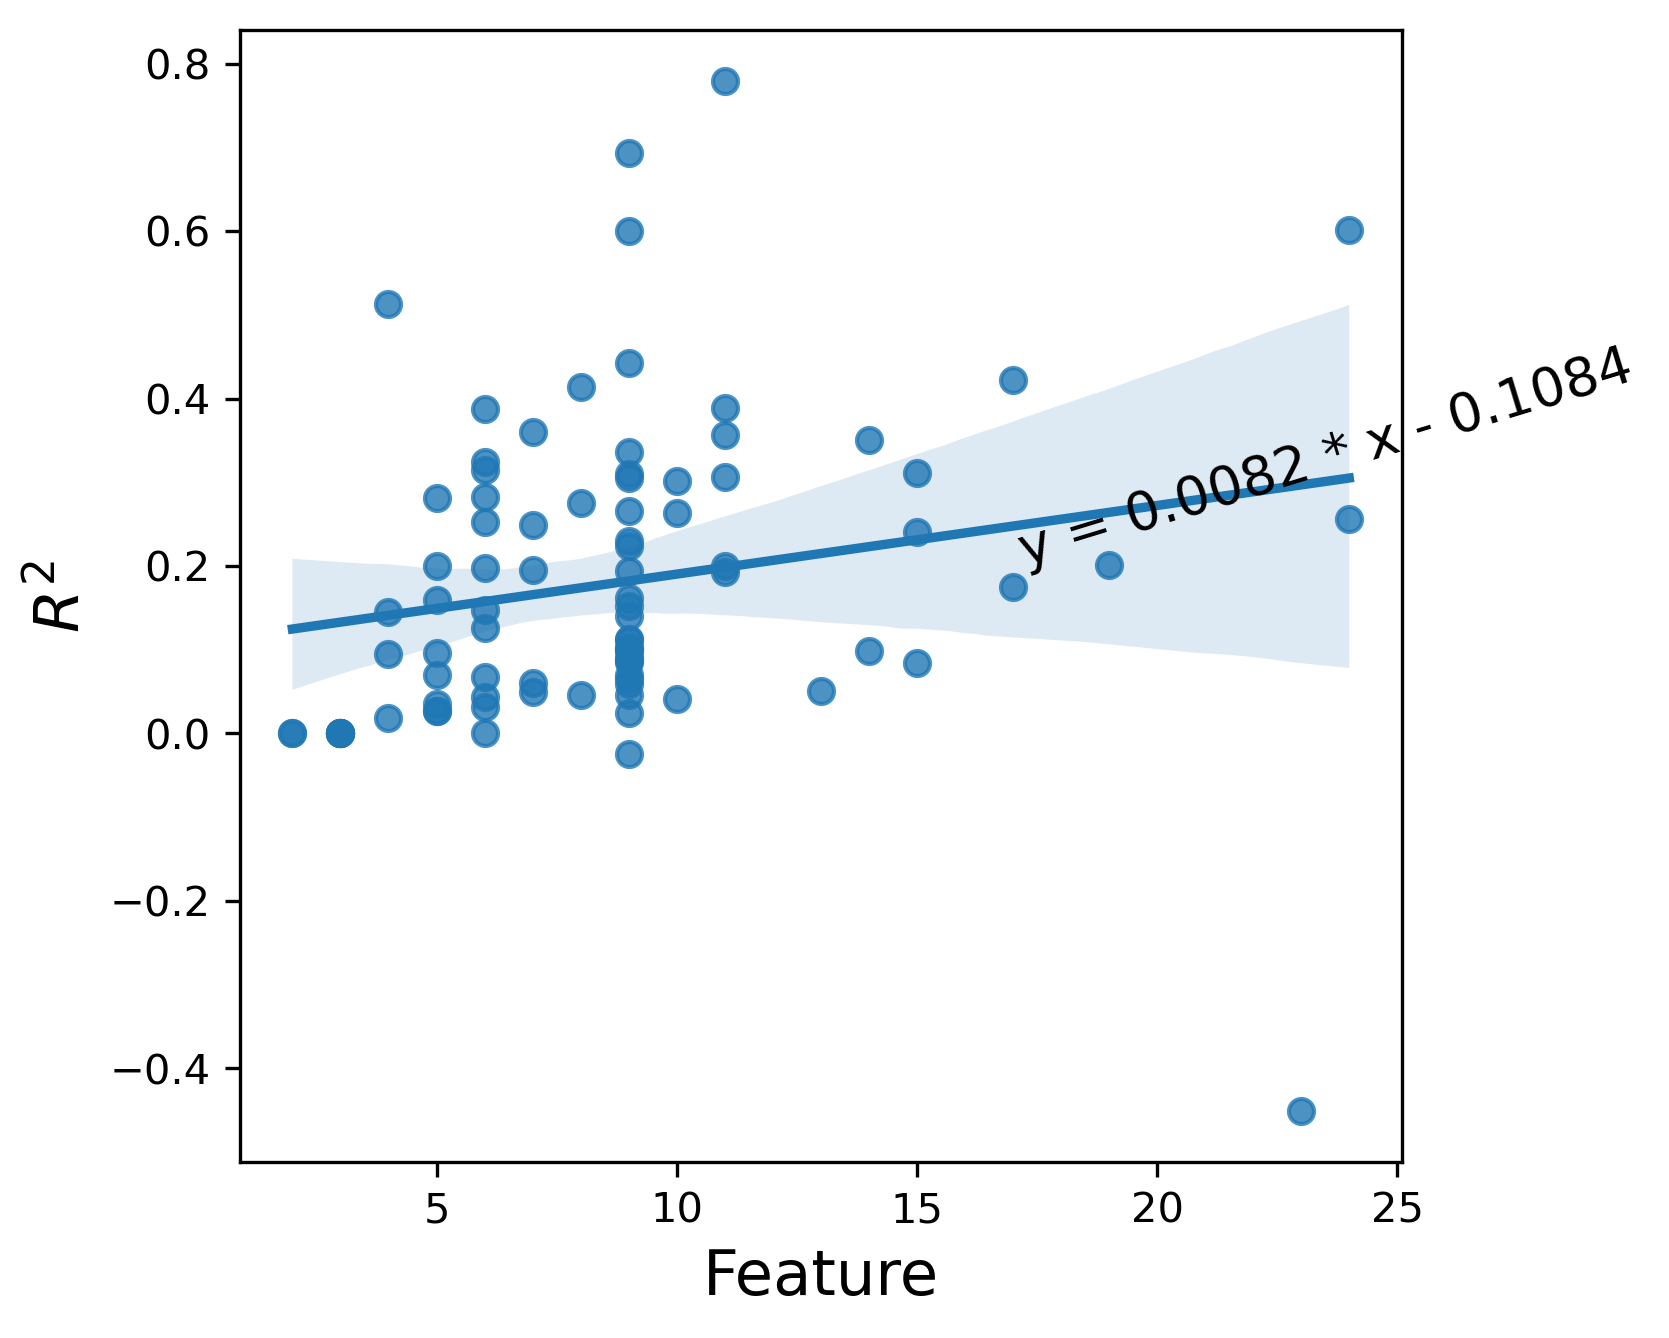

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     R2   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.716
Date:                Fri, 14 Jul 2023   Prob (F-statistic):             0.0572
Time:                        14:08:22   Log-Likelihood:                 28.470
No. Observations:                  88   AIC:                            -52.94
Df Residuals:                      86   BIC:                            -47.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1084      0.041      2.630      0.010       0.026       0.190
Feature        0.0082      0.004      1.928      0.057      -0.000       0.017
==============================================================================
Omnibus:                       15.155   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               60.043
Skew:                           0.174   Prob(JB):                     9.16e-14
Kurtosis:                       7.032   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
fig = plt.figure(0, (5, 5), dpi=300)
p = sns.regplot(x="Feature", y="R2", data=result)
slope, intercept, r_value, p_value, std_err = stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
_ = plt.annotate('y = '+str(round(slope, 4))+' * x - '+str(round(abs(intercept), 4)), (17, 0.2), fontsize=13, rotation=17)

_ = plt.xlabel('Feature', fontsize=15)
_ = plt.ylabel('$R^2$', fontsize=15)
#plt.savefig('../Results/Results2/2.Feature_lineFit.pdf',bbox_inches = 'tight')
_ = plt.show()

X = result['Feature']
X = sm.add_constant(X)
y = result['R2']
est=sm.OLS(y, X)
est=est.fit()
est.summary()

In [25]:
feature_set = list(feature_set)
index = list(importances.keys())
result = pd.DataFrame(np.zeros((len(importances), len(feature_set))), index=index, columns=feature_set)
for p in index:
    for l in feature_set:
        result.loc[p, l] = importances[p].get(l, np.nan)
count = (result.shape[0]-result.isnull().sum()).sort_values(ascending=False)
count.loc[count>5]

age_category_adult                   70
age                                  68
gender_male                          63
age_category_senior                  48
BMI                                  48
age_category_child                   19
country_USA                          18
antibiotics_family_cephalosporins    15
hba1c                                15
country_FIN                          15
country_EST                          15
country_CHN                          15
age_category_newborn                 14
hla_drb12                            12
hla_dqa12                            12
hla_drb11                            12
country_RUS                          12
antibiotics_family_penicillins       12
hla_dqa11                            12
triglycerides                        11
hdl                                  11
ldl                                  11
smoker_yes                           10
cholesterol                          10
country_DNK                           9


,age,gender_male,BMI,country_USA,country_FIN,country_EST,country_CHN,hba1c,hdl,ldl,...,triglycerides,smoker_yes,cholesterol,creatinine,fobt_yes,hscrp,treatment_metformin,brinkman_index,fasting_glucose,alcohol_numeric
08,0.000000,0.006835,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09,0.005995,0.045214,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


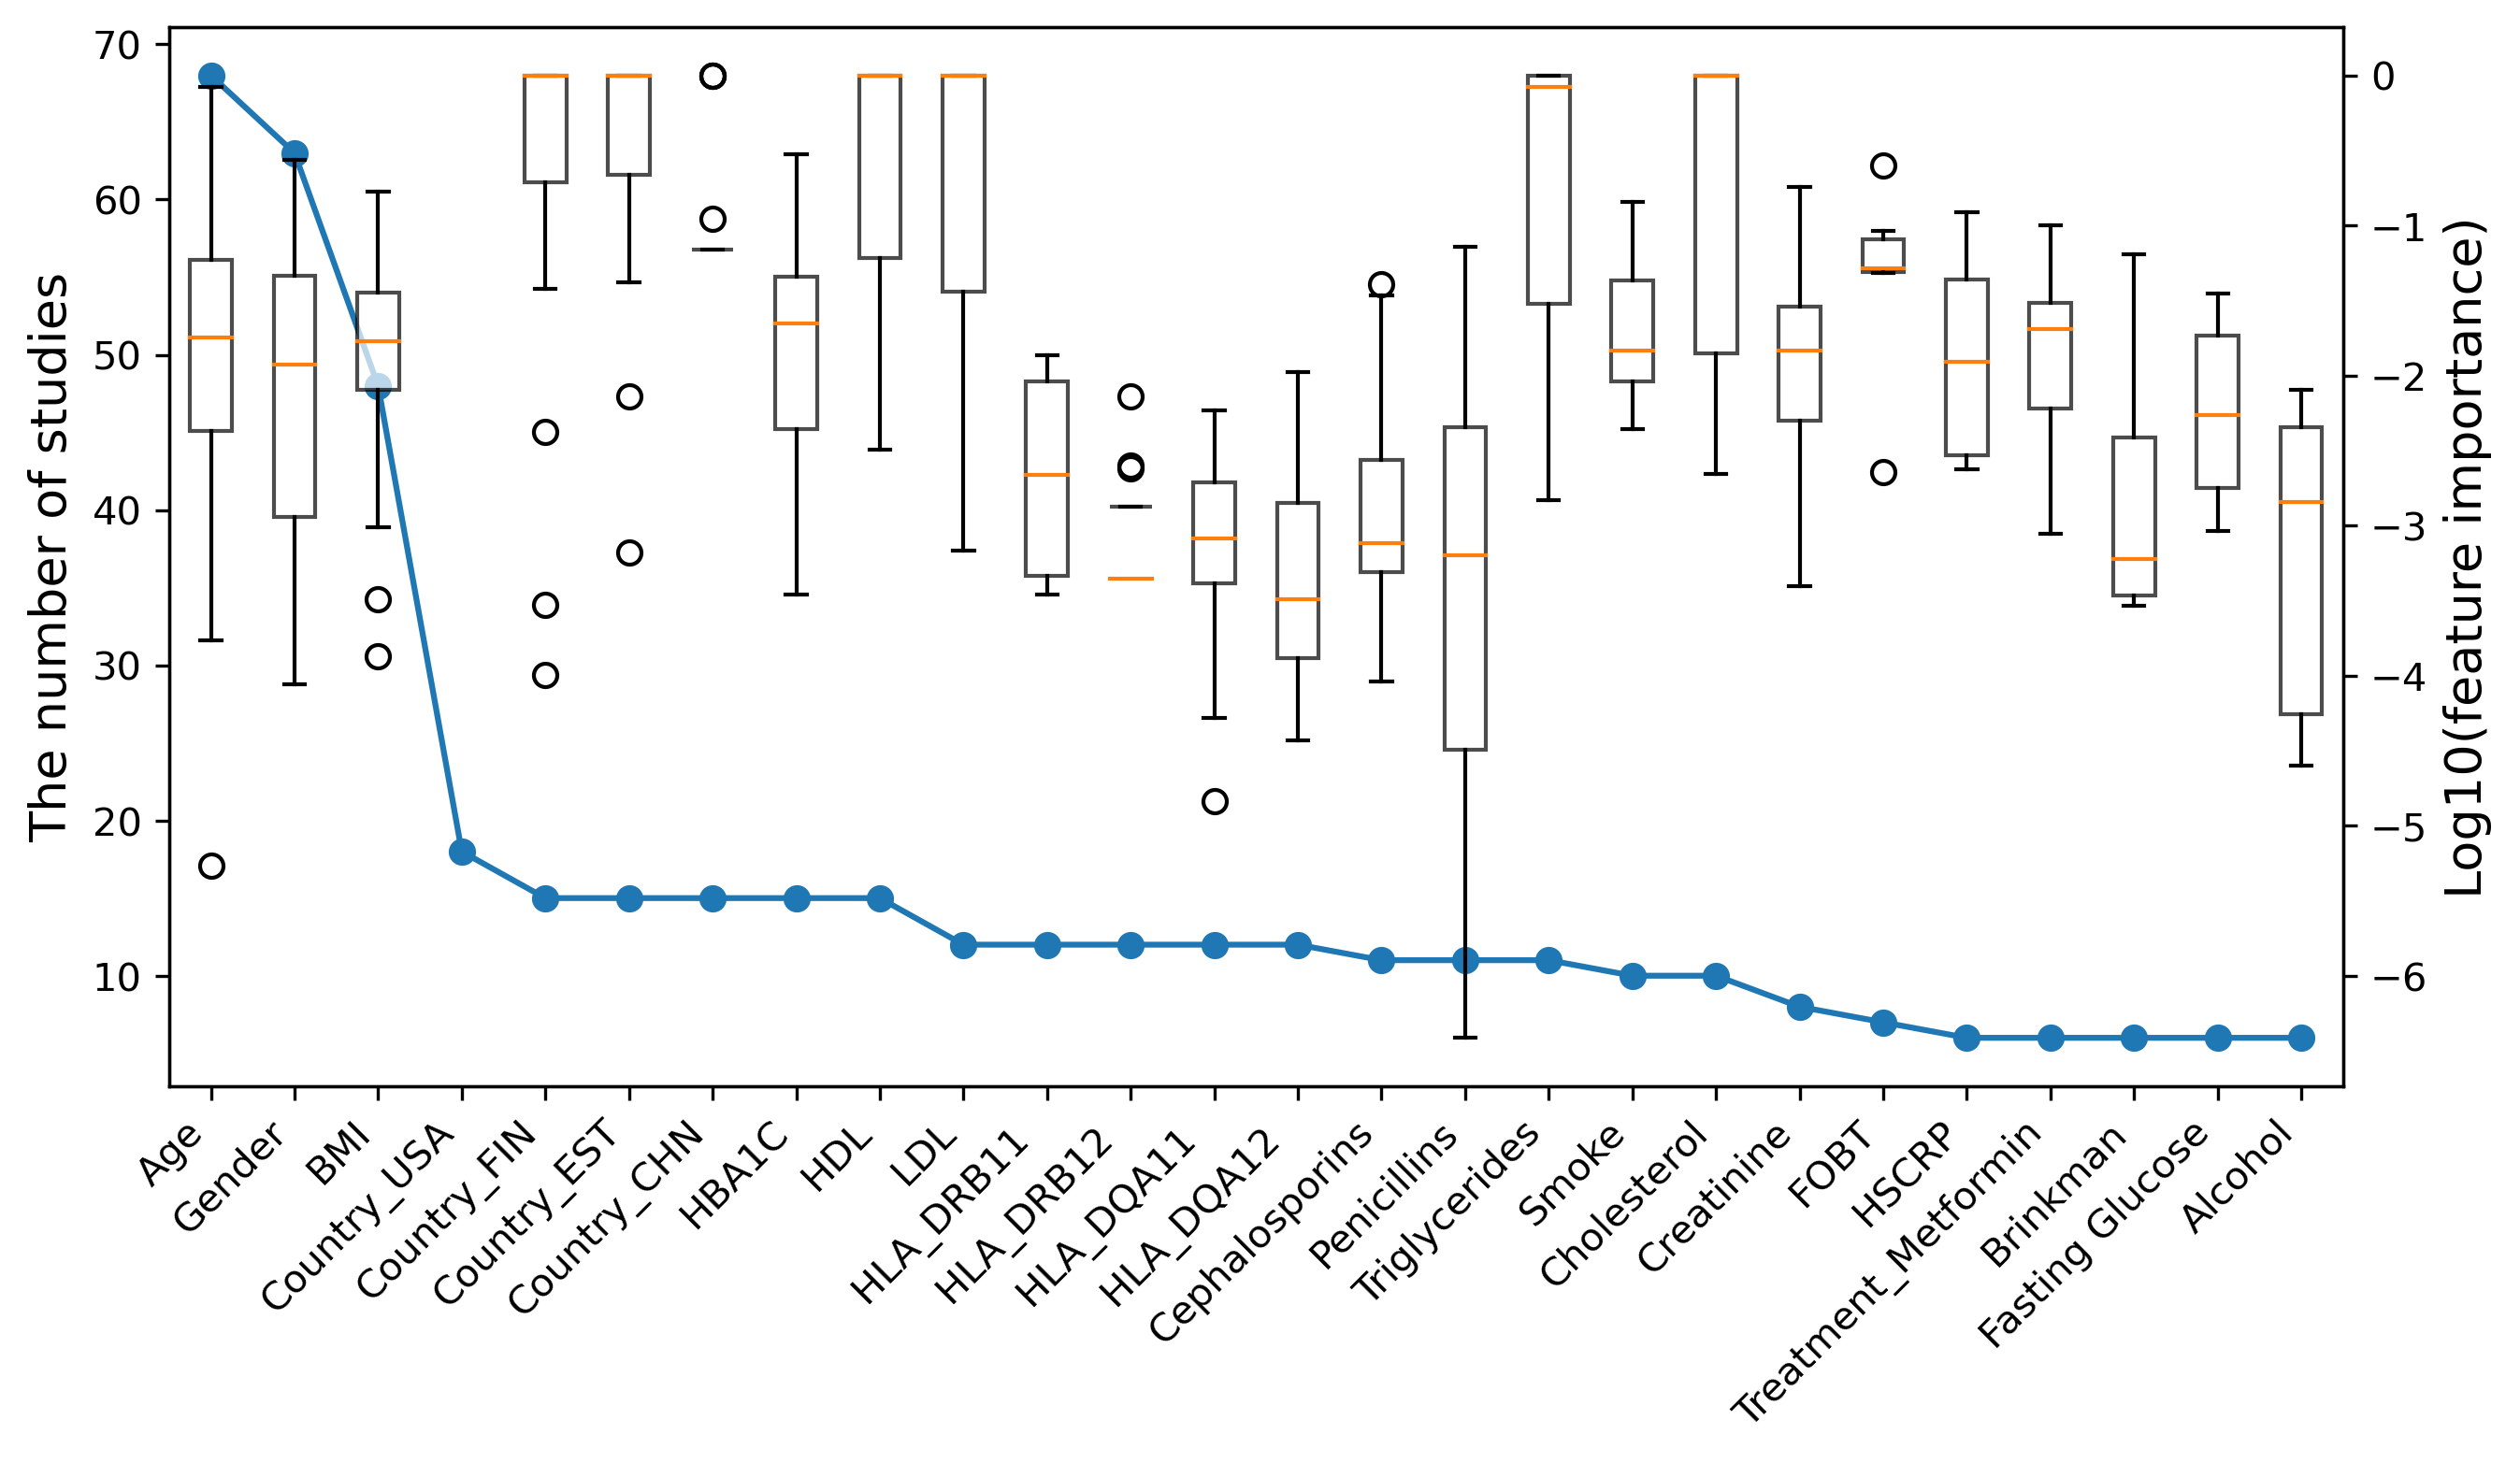

In [26]:
features = np.array([('age', 'Age'),('gender_male', 'Gender'), ('BMI', 'BMI'), 
                     ('country_USA','Country_USA'),('country_FIN','Country_FIN'),('country_EST','Country_EST'),('country_CHN','Country_CHN'),
                     ('hba1c','HBA1C'),('hdl', 'HDL'), ('ldl', 'LDL'), 
                     ('hla_drb11','HLA_DRB11 '),('hla_drb12','HLA_DRB12 '),
                     ('hla_dqa11','HLA_DQA11 '),('hla_dqa12','HLA_DQA12 '),
                     ('antibiotics_family_cephalosporins','Cephalosporins'),
                     ('antibiotics_family_penicillins','Penicillins'),
                     ('triglycerides','Triglycerides'),('smoker_yes','Smoke'),
                     ('cholesterol','Cholesterol'),('creatinine','Creatinine'),('fobt_yes','FOBT'),
                     ('hscrp','HSCRP'),('treatment_metformin','Treatment_Metformin'),
                     ('brinkman_index','Brinkman'),('fasting_glucose','Fasting Glucose'),('alcohol_numeric','Alcohol')])
results = result.loc[:, features[:,0]]
results.head(2)
results.columns = features[:, 1]
count = (results.shape[0]-results.isnull().sum()).sort_values(ascending=False)
#result.head(2)

plot_feature = features[:, 1][:]
fig = plt.figure(0, (10, 5), dpi=300)
ax = fig.add_subplot(111)
_ = plt.plot(np.arange(len(plot_feature))+1, count.values, '-', marker='o')
_ = plt.xticks(np.arange(len(plot_feature))+1, plot_feature, rotation=45, ha='right')
#_ = plt.yticks([5, 10, 15, 20], [5, 10, 15, 20])
_ = plt.ylabel('The number of studies', fontsize=13)

ax2 = ax.twinx()
bp = plt.boxplot([np.log10(np.clip(results[i].dropna(), 0, 1)) for i in plot_feature], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('white')
    patch.set_alpha(0.7)
_ = plt.xticks(np.arange(len(plot_feature))+1, plot_feature, rotation=45, ha='right')
_ = plt.ylabel('Log10(feature importance)', fontsize=13)
#plt.savefig('../Results/Results2/2.Feature_importance.pdf',bbox_inches = 'tight')
_ = plt.show()